In [0]:
#!pip uninstall tensorflow

In [0]:
#!pip install tensorflow-gpu==2.0.0

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import time
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as mpatches
from sklearn.metrics import roc_auc_score
import random
import itertools
from sklearn.metrics import confusion_matrix
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
from skopt import gp_minimize #貝氏優化
from skopt.space import Real, Integer
from skopt.utils import use_named_args

print(tf.__version__)

2.0.0


In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
tf.compat.v1.Session(config=config)

## pretrain

In [3]:
names = np.array(['airplane',
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck'])

In [4]:
flatten_size = 32 * 32 * 3
img_size = 32
img_channel = 3
regular = 1e-5

z_dim = 128
h_dim = [32, 64, 128]
objective = 'deep-SVDD'     #'  'soft-boundary'


In [5]:
class Autoencoder():
    
    def __init__(self, label_num, img_size = img_size, z_dim = z_dim, h_dim = h_dim, img_channel = img_channel):
        names = np.array(['airplane',
        'automobile',
        'bird',
        'cat',
        'deer',
        'dog',
        'frog',
        'horse',
        'ship',
        'truck'])
        self.label_num = label_num
        self.label_name = names[label_num]
        self.flatten_size = img_size * img_size * img_channel
        self.z_dim = z_dim
        self.h_dim = h_dim
        self.encoder = self.make_encoder()
        self.decoder = self.make_decoder()
        self.ae_optimizer = tf.keras.optimizers.Adam(lr = 0.001, epsilon = 1e-6)
        

    def make_encoder(self):

        inputs = tf.keras.Input(shape=(self.flatten_size,), name='inputs')
        x = tf.reshape(inputs, shape = (-1, 32, 32, 3))
        x = tf.keras.layers.Conv2D(self.h_dim[0], (5, 5), activation='linear', padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization(epsilon = 1e-04)(x)
        x = tf.keras.layers.ELU()(x)
        x = tf.keras.layers.MaxPool2D((2, 2), padding='same')(x)

        x = tf.keras.layers.Conv2D(self.h_dim[1], (5, 5), activation='linear', padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization(epsilon = 1e-04)(x)
        x = tf.keras.layers.ELU()(x)
        x = tf.keras.layers.MaxPool2D((2, 2), padding='same')(x)
        
        x = tf.keras.layers.Conv2D(self.h_dim[2], (5, 5), activation='linear', padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization(epsilon = 1e-04)(x)
        x = tf.keras.layers.ELU()(x)
        x = tf.keras.layers.MaxPool2D((2, 2), padding='same')(x)

        x = tf.keras.layers.Flatten(name = 'Flatten')(x)
        x = tf.keras.layers.BatchNormalization(epsilon = 1e-04)(x)
        x = tf.keras.layers.Dense(self.z_dim, use_bias = False, name = 'dense')(x)
        
        
        model = tf.keras.Model(inputs=inputs, outputs=x)

        return model    
   
    def make_decoder(self):

        inputs = tf.keras.Input(shape=(self.z_dim,), name='inputs')
        x = tf.reshape(inputs, shape = (-1, 4, 4, 8))
        x = tf.keras.layers.LeakyReLU()(x)
        #x = tf.keras.layers.UpSampling2D((2, 2))(x)    

        x = tf.keras.layers.Conv2DTranspose(self.h_dim[2], (5, 5), padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ELU()(x)
        x = tf.keras.layers.UpSampling2D((2, 2))(x)   

        x = tf.keras.layers.Conv2DTranspose(self.h_dim[1], (5, 5), padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ELU()(x)
        x = tf.keras.layers.UpSampling2D((2, 2))(x)
        
        x = tf.keras.layers.Conv2DTranspose(self.h_dim[0], (5, 5), padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ELU()(x)
        x = tf.keras.layers.UpSampling2D((2, 2))(x) 
        
        x = tf.keras.layers.Conv2DTranspose(3, (5, 5), activation='sigmoid', padding='same',  use_bias = False)(x)
        #x = tf.reshape(x, shape = (-1, self.flatten_size))
        x = tf.keras.layers.Flatten(name = 'Flatten')(x)
        model = tf.keras.Model(inputs=inputs, outputs=x)

        return model  
    
    @tf.function
    def train_ae_model(self, batch_x):
        with tf.GradientTape() as ae_tape:
            ae_output = self.decoder(self.encoder(batch_x, training=True), training=True)
            loss = tf.reduce_mean((ae_output - batch_x) ** 2)

        grads = ae_tape.gradient(loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
        self.ae_optimizer.apply_gradients(zip(grads, self.encoder.trainable_variables + self.decoder.trainable_variables))

        return loss
    
    def train_ae( self, n_ae_epochs, train_dataset):
        #loss_list = []
        for epoch in range(n_ae_epochs):
            epoch_ae_loss_avg = tf.metrics.Mean()
            if (epoch+1) % 250 == 0:
                self.ae_optimizer.lr = 0.1 * self.ae_optimizer.lr
            for batch, (batch_x) in enumerate(train_dataset):

                ae_loss = self.train_ae_model(batch_x)
                #epoch_ae_loss_avg(ae_loss)
            #loss_list.append(epoch_ae_loss_avg.result())
        
        self.encoder.save_weights('D:/7107018014/checkpoints/revist_deepSVDD/model_label_{}'.format(
            self.label_name))
        #print('LOSS: {:.4f} '.format(epoch_ae_loss_avg.result()))
        #plt.title('label = {}'.format(self.label_name))
        #plt.plot(loss_list)
        #plt.show()
        

## training data

In [6]:
def load_data(label_num, batch_size = 200, outlier_nu = 0.1):
    # 0: normal, 1: outlier
    print("Loading ",names[label_num]," data...")
    x_train = np.load('D:/7107018014/cifar10/{}/{}_data{}_batch{}.npy'.format(label_num,'train',label_num, 0))
    y_train = np.load('D:/7107018014/cifar10/{}/{}_label{}_batch{}.npy'.format(label_num,'train',label_num, 0))
    x_train = np.transpose(x_train, (0, 2, 3, 1))
    
    
    for i in np.arange(2):
        data = np.load('D:/7107018014/cifar10/{}/{}_data{}_batch{}.npy'.format(label_num,'test',label_num, i))
        label = np.load('D:/7107018014/cifar10/{}/{}_label{}_batch{}.npy'.format(label_num,'test',label_num, i))
        
        data = np.transpose(data, (0, 2, 3, 1))
        try:
            x_test = np.vstack((x_test, data))
            y_test = np.hstack((y_test, label))
        except:
            x_test = data
            y_test = label
    ## outlier data
    for index in np.delete(np.arange(10), label_num):
        
        out_data = np.load('D:/7107018014/cifar10/{}/{}_data{}_batch{}.npy'.format(index,'train',index, 0))
        out_label = np.load('D:/7107018014/cifar10/{}/{}_label{}_batch{}.npy'.format(index,'train',index, 0))

        out_data = np.transpose(out_data, (0, 2, 3, 1))
        try:
            out_datas_ = np.vstack((out_datas_, out_data))
            out_labels_ = np.hstack((out_labels_, out_label))
        except:
            out_datas_ = out_data
            out_labels_ = out_label
        
    ### 製造outlier
    random.seed (1120)
    normal_n = len(x_train)
    outlier_n = len(out_datas_) ####
    indices = np.random.choice(outlier_n, int(normal_n * outlier_nu), replace=False)
    x_train = np.vstack( (x_train[y_train == label_num], out_datas_[indices]))
    y_train = np.hstack( (y_train[y_train == label_num], out_labels_[indices]))
    
    
    # Flatten the dataset
    x_train = x_train.reshape((-1, flatten_size))
    x_test = x_test.reshape((-1, flatten_size))

    
    return x_train, x_test, y_train, y_test

In [7]:
def load_notransform_data(label_num, batch_size = 200, outlier_nu = 0.1):
    # 0: normal, 1: outlier
    print("Loading ",names[label_num]," data...")
    x_train = np.load('D:/7107018014/notransform_cifar/{}/{}_data{}_batch{}.npy'.format(label_num,'train',label_num, 0))
    y_train = np.load('D:/7107018014/notransform_cifar/{}/{}_label{}_batch{}.npy'.format(label_num,'train',label_num, 0))
    x_train = np.transpose(x_train, (0, 2, 3, 1))
    for i in np.arange(2):
        data = np.load('D:/7107018014/notransform_cifar/{}/{}_data{}_batch{}.npy'.format(label_num,'test',label_num, i))
        label = np.load('D:/7107018014/notransform_cifar/{}/{}_label{}_batch{}.npy'.format(label_num,'test',label_num, i))
        data = np.transpose(data, (0, 2, 3, 1))
        try:
            x_test = np.vstack((x_test, data))
            y_test = np.hstack((y_test, label))
        except:
            x_test = data
            y_test = label
    ## outlier data
    for index in np.delete(np.arange(10), label_num):
        out_data = np.load('D:/7107018014/notransform_cifar/{}/{}_data{}_batch{}.npy'.format(index,'train',index, 0))
        out_label = np.load('D:/7107018014/notransform_cifar/{}/{}_label{}_batch{}.npy'.format(index,'train',index, 0))
        out_data = np.transpose(out_data, (0, 2, 3, 1))
        try:
            out_datas_ = np.vstack((out_datas_, out_data))
            out_labels_ = np.hstack((out_labels_, out_label))
        except:
            out_datas_ = out_data
            out_labels_ = out_label
    ### 製造outlier
    random.seed (1120)
    normal_n = len(x_train)
    outlier_n = len(out_datas_) ####
    indices = np.random.choice(outlier_n, int(normal_n * outlier_nu), replace=False)
    x_train = np.vstack( (x_train[y_train == label_num], out_datas_[indices]))
    y_train = np.hstack( (y_train[y_train == label_num], out_labels_[indices]))
    # Flatten the dataset
    x_train = x_train.reshape((-1, flatten_size))
    x_test = x_test.reshape((-1, flatten_size))
    return x_train, x_test, y_train, y_test

## 資料分割

In [8]:
def split_data(x_train, batch_size = 200):
    
    x_, x_vali, = train_test_split(x_train, test_size = 0.2, random_state = 42)
    n_samples = len(x_)
    no_vali_dataset = tf.data.Dataset.from_tensor_slices(x_)
    no_vali_dataset = no_vali_dataset.shuffle(buffer_size=1000)
    no_vali_dataset = no_vali_dataset.batch(batch_size)
    
    train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
    train_dataset = train_dataset.shuffle(buffer_size=1000)
    train_dataset = train_dataset.batch(batch_size)
    
    
    
    x_vali_tensor = tf.convert_to_tensor(x_vali)
    validation_n = len(x_vali)
    
    return no_vali_dataset, train_dataset, x_vali_tensor, n_samples, validation_n

## SVDD 模型(encoder 初始值 + certer初始值)

In [9]:
class make_SVDD_model():
    def __init__(self, train_dataset , encoder, z_dim = z_dim):
        self.encoder = encoder
        self.z_dim = z_dim
        self.train_dataset = train_dataset
        self.SVDD_model = self.make_model()
        
        
    def init_center_c(self, eps = 0.1):

        positive = tf.fill([self.z_dim], eps)
        negative = tf.fill([self.z_dim], -eps)
        c = tf.zeros(shape = [self.z_dim], dtype = tf.float32, name = 'c')
        
        for batch, (batch_x) in enumerate(self.train_dataset):
            output = self.encoder(batch_x, training=False)            
            if batch ==0:
                modeloutput = output
            else:
                modeloutput = tf.concat([modeloutput, output], 0)
        
        c = tf.reduce_mean(modeloutput, axis = 0, name = 'outputs') 
        # If c_i is too close to 0, set to +-eps. Reason: a zero unit can be trivially matched with zero weights.

        c = tf.where(tf.logical_and(tf.less(c, 0), tf.greater(c, -eps)), negative, c)
        c = tf.where(tf.logical_and(tf.greater(c, 0), tf.less(c, eps)), positive, c)
        
        return c
    
    def initializer(self):
        
        bias_init = np.array(self.init_center_c( eps = 0.1))
        kernel_initializer = self.encoder.get_layer('dense').get_weights()[0]
        
        return bias_init, kernel_initializer
    
    def make_model(self):
        
        bias_init, kernel_initializer = self.initializer()
        
        self.encoder.trainable = True
        x = self.encoder.get_layer('Flatten').output
        outputs = tf.keras.layers.Dense(
        self.z_dim, activation=None, kernel_initializer = tf.constant_initializer(kernel_initializer), 
            use_bias=True, bias_initializer = tf.constant_initializer(bias_init))(x)
        model_new = tf.keras.Model(inputs = self.encoder.input, outputs = outputs)
    
        return model_new   #, bias_init 原始center
    

## 訓練結果

In [10]:
def distance_plot(label_num, dist, radius_end, name, train = True, label = None):
    treshold = radius_end ** 2
    if train:
        plt.title(str(objective) + 'label = {} train data'.format(name))
        if objective == 'soft-boundary':
            treshold = 0
            plt.hist(dist[label == label_num], rwidth=0.3, color='b' ,bins = 100,label = 'normal')
            if sum(label!=label_num):
                plt.hist(dist[label != label_num], rwidth = 0.3, color = 'r',label = 'anomaly', bins = 100)
                plt.axvline(treshold,  color='g')
                plt.legend()
        else:
            plt.hist(dist[label == label_num], rwidth=0.3, color='b' ,bins = 100,label = 'normal')
            if sum(label!=label_num):
                plt.hist(dist[label != label_num], rwidth = 0.3, color = 'r',label = 'anomaly', bins = 100)
                plt.axvline(treshold,  color='g')
                plt.legend()
        plt.show()       
    
    else:
        plt.title(str(objective) + 'label = {} test data'.format(name))
        if objective == 'soft-boundary':
            plt.hist(dist[label!=label_num], rwidth=0.3, color='r' ,bins = 100,label = 'anomaly')
            plt.hist(dist[label==label_num], rwidth = 0.3, color = 'b',label = 'normal', bins = 100)
            plt.axvline(treshold,  color='g')
            plt.legend()

        else:
            plt.hist(dist[label!=label_num], rwidth=0.3, color='r' ,bins = 100,label = 'anomaly')
            plt.hist(dist[label==label_num], rwidth=0.3, color='b' ,bins = 100,label = 'normal')
            plt.axvline(float(treshold), color='g')
            plt.legend()

        plt.legend()
        plt.show()
    


In [11]:
def threshold_img(data, dist2radius):
    dict_score = {}
    for i in range(len(dist2radius)):
        dict_score[float(dist2radius[i])] = i
    sort_score = [(k, dict_score[k]) for k in sorted(dict_score.keys())]
    
    n_digits = 10  # how many digits we will display
    fig = plt.figure(figsize=(20, 4))
    for i in range(1, n_digits):
        # display normal
        ax = plt.subplot(2, n_digits, i + 1)
        plt.imshow(data[sort_score[i][1]].reshape(img_size, img_size, img_channel), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display anomaly
        ax = plt.subplot(2, n_digits, i + 1 + n_digits)
        plt.imshow(data[sort_score[-i][1]].reshape(img_size, img_size, img_channel), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


In [12]:
def threshold_uncertain_img(data, dists, r):
    dist2radius = (dists - r**2)
    normal = dist2radius[dist2radius<0]
    anomaly = dist2radius[dist2radius>0]
    normal_score = {}
    anomaly_score = {}
    for i in range(len(normal)):
        normal_score[float(normal[i])] = i
    for i in range(len(anomaly)):
        anomaly_score[float(anomaly[i])] = i
    normalsort_score = [(k, normal_score[k]) for k in sorted(normal_score.keys())]
    anomalysort_score = [(k, anomaly_score[k]) for k in sorted(anomaly_score.keys())]
    
    n_digits = min([len(normal),len(anomaly),10])#20  # how many digits we will display
    fig = plt.figure(figsize=(20, 4))
    #print('normal:', len(normal), 'anomaly', len(anomaly))
    for i in range(1, n_digits):
        # display normal
        ax = plt.subplot(2, n_digits, i + 1)
        plt.imshow(data[normalsort_score[-i][1]].reshape(img_size, img_size, img_channel), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display anomaly
        ax = plt.subplot(2, n_digits, i + 1 + n_digits)
        plt.imshow(data[anomalysort_score[i][1]].reshape(img_size, img_size, img_channel), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [13]:
def false_img(data, labels_,  dists, r, label_num):
    dist2radius = (dists - r**2)
    dist_n = dist2radius[labels_ != label_num]
    dist_p = dist2radius[labels_ == label_num]
    data_n = data[labels_ != label_num]
    data_p = data[labels_ == label_num]
    fn = dist_n[dist_n<0]
    fp = dist_p[dist_p>0]
    fn_score = {}
    fp_score = {}
    for i in range(len(fn)):
        fn_score[float(fn[i])] = i
    for i in range(len(fp)):
        fp_score[float(fp[i])] = i
        
    fn_score_sort = [(k, fn_score[k]) for k in sorted(fn_score.keys())]
    fp_score_sort = [(k, fp_score[k]) for k in sorted(fp_score.keys())]
    
    if sum(labels_ != label_num) > 0:
    
        n_digits = min([len(fn),len(fp),10])#20  # how many digits we will display
        fig = plt.figure(figsize=(20, 4))
        #print('normal:', len(normal), 'anomaly', len(anomaly))
        for i in range(1, n_digits):
            # display fn
            ax = plt.subplot(2, n_digits, i + 1)
            plt.imshow(data_n[fn_score_sort[-i][1]].reshape(img_size, img_size, img_channel), cmap = plt.cm.gray)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display fp
            ax = plt.subplot(2, n_digits, i + 1 + n_digits)
            plt.imshow(data_p[fp_score_sort[i][1]].reshape(img_size, img_size, img_channel), cmap = plt.cm.gray)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.show()
        
    else:
        n_digits = min([len(fp),10])
        fig = plt.figure(figsize=(20, 4))
        #print('normal:', len(normal), 'anomaly', len(anomaly))
        for i in range(1, n_digits):

            # display fp
            ax = plt.subplot(2, n_digits, i + 1 + n_digits)
            plt.imshow(data_p[fp_score_sort[i][1]].reshape(img_size, img_size, img_channel), cmap = plt.cm.gray)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.show()

## Train SVDD_model

In [14]:
class SA_DeepSVDD_Trainer():
    
    def __init__(self, label_num, nu, SVDD_model, n_samples, validation_n, smoothing, warm_up_n_epochs,
                 lr_milestone, lr_change):
        names = np.array(['airplane',
        'automobile',
        'bird',
        'cat',
        'deer',
        'dog',
        'frog',
        'horse',
        'ship',
        'truck'])
        self.lr_change = lr_change
        self.label_num = label_num
        self.label_name = names[label_num]
        self.SVDD_model = SVDD_model
        self.n_samples = n_samples
        self.validation_n = validation_n
        self.nu = nu
        self.smoothing = smoothing
        self.warm_up_n_epochs = warm_up_n_epochs
        self.lr_milestone = lr_milestone
        
        ## 設置lagrange因子、Radius
        self.radius = tf.Variable(0., dtype=tf.float32, name="radius2", trainable=True)
        self.optimizer = tf.keras.optimizers.Adam(lr = 5e-4, epsilon = 1e-6)
        
    def get_radius(self, batch_x):
        ## Optimally solve for radius R via the (1-nu)-quantile of distances.
 
        modeloutput = self.SVDD_model(batch_x, training=False)

        distance = tf.reduce_sum(tf.square(modeloutput),1)
        
        return tfp.stats.percentile(tf.sqrt(distance), (1 - self.nu)*100)
  
    def loss_function(self, output, radius, tau):

        C = 1/(self.n_samples * self.nu)
        slack = tf.reduce_sum(tf.square(output), 1) - tf.square(radius)
        objective = tf.square(radius) + C * (1/tau)* tf.reduce_sum(tf.math.softplus(tau * slack))

        return objective
    
    def validation_objective_loss(self, data, tau):
        
        C = 1/(self.validation_n * self.nu)
        output_square = tf.reduce_sum(tf.square(self.SVDD_model(data, training=False)) , 1)
        validation_slack = output_square - tf.square(self.radius)
        objective = tf.square(self.radius) + C * (1/tau)* tf.reduce_sum(tf.math.softplus(tau * validation_slack))

        return objective

    @tf.function
    def train_model(self, data, radius, tau):
        with tf.GradientTape() as tape:

            output = self.SVDD_model(data, training=True)
            loss_train = self.loss_function( output, radius, tau)

        grads = tape.gradient(loss_train, (self.SVDD_model.trainable_variables))
        self.optimizer.apply_gradients(zip(grads, (self.SVDD_model.trainable_variables)))

        return loss_train
    
    def valistation_train(self, train_dataset, x_vali_tensor ,  max_lr = 1e-8, base_lr = 1e-4, max_tau = 15):
        objective_break = False
   
        objective_list = []
        validation_loss_list = []

        
        pre_objective_loss = np.inf
        objective_loss = 0
        pre_validation_loss = np.inf
        objective_loss = 0
        
        objective = 0.
        epoch = 0
        tau = 1
        while abs(pre_objective_loss - objective_loss) > 1e-8:

            epoch_loss_avg = tf.metrics.Mean()

            pre_objective_loss = objective_loss
            if (epoch+1) % self.lr_milestone == 0:
                self.optimizer.lr = self.lr_change  * self.optimizer.lr

            for batch, (batch_x) in enumerate(train_dataset):
                loss = self.train_model(batch_x, self.radius, tau)
                epoch_loss_avg(loss)
                if (epoch >= self.warm_up_n_epochs):
                    self.radius = self.get_radius(batch_x)
                
            validation_loss = self.validation_objective_loss(x_vali_tensor, tau)
            objective_loss = epoch_loss_avg.result()

            objective_list.append(objective_loss)
            validation_loss_list.append(validation_loss)
            
            ## 檢查early stopping
            if epoch > (self.warm_up_n_epochs ) + 6 and epoch % 5 == 0:
                if pre_validation_loss - validation_loss < 0:
                    objective_break = True
                    break

            pre_validation_loss  =  validation_loss #######################
            
            ##改變tau
            if epoch  > self.warm_up_n_epochs and (epoch + 1) % self.smoothing == 0 and tau < max_tau :
                tau += 1
            '''
            if epoch % 50==0:
                print('{:4d}: R: {:.4f} objective loss:{:4f}  tau {:} lr:{:4f}'.format(
            epoch, self.radius.numpy(), objective_loss, tau, self.optimizer.lr.numpy()))
                self.train_result(x_train, load_model = False)
                self.test_result(x_test, y_test, load_model = False)
            '''
            epoch += 1
        
        #print('{:4d}: R: {:.4f} objective loss:{:4f}  lr:{:4f}'.format(
            #epoch, self.radius.numpy(), objective_loss,  self.optimizer.lr.numpy()))
        ### 決定使用的model
        if objective_break:
            epoch = epoch - 5
            
        
        validation_loss = self.validation_objective_loss(x_vali_tensor, tau) ## 挑超參數
        ## 劃出loss結果

        plt.plot(objective_list, label = 'train')
        plt.plot(validation_loss_list, label = 'validation')
        plt.title('{} loss'.format(self.label_name))
        plt.legend()
        plt.show()
        '''
        plt.plot(objective_list[-1000:])
        plt.title('last 1000 train objective loss')
        plt.show()
        plt.plot(validation_loss_list[-1000:])
        plt.title('last 1000 validation objective loss')
        plt.show()
        '''
        return epoch
    
    def last_train(self, train_dataset, epoch_n ,  max_lr = 1e-8, base_lr = 1e-4, max_tau = 15):
        
        tau = 1
        for epoch in range(epoch_n):

            epoch_loss_avg = tf.metrics.Mean()
            if (epoch+1) % self.lr_milestone == 0:
                self.optimizer.lr = self.lr_change  * self.optimizer.lr

            for batch, (batch_x) in enumerate(train_dataset):
                loss = self.train_model(batch_x, self.radius, tau)
                epoch_loss_avg(loss)
                if (epoch >= self.warm_up_n_epochs):
                    self.radius = self.get_radius(batch_x)
                            
            ##改變tau
            if epoch  > self.warm_up_n_epochs and (epoch + 1) % self.smoothing == 0 and tau < max_tau :
                tau += 1
    
        self.SVDD_model.save_weights('D:/7107018014/checkpoints/SAdeepSVDD/model_label_{}_outlier{}'.format(
                    self.label_name, self.nu))
        np.save('D:/7107018014/checkpoints/SAdeepSVDD/radius_label_{}_outlier{}'.format(
                    self.label_name, self.nu), self.radius.numpy())
    
    def difference_between_center(self, x_train, ori_center):
        
        new_center =  tf.reduce_mean(self.SVDD_model(x_train, training = False), axis = 0)
        difference = ori_center - new_center
            
        print('difference_between_center',difference.numpy())       
        
    def distance(self, data, label, load_model = True):
        if load_model:
            self.SVDD_model.load_weights('D:/7107018014/checkpoints/SAdeepSVDD/model_label_{}_outlier{}'.format(
                    self.label_name, self.nu))
            radius_end = np.load('D:/7107018014/checkpoints/SAdeepSVDD/radius_label_{}_outlier{}.npy'.format(
                    self.label_name, self.nu))

        
        batch_size = 200
        train_dataset = tf.data.Dataset.from_tensor_slices((data,label))
        train_dataset = train_dataset.batch(batch_size)

        for batch, (batch_x, batch_y) in enumerate(train_dataset):
            output = self.SVDD_model(batch_x, training=False)
            dist = tf.reduce_sum(tf.math.square(output) , axis=1) ## dist**2
            
            if batch ==0:
                dis_square = dist
                labels_ = batch_y
                datas = batch_x
            else:
                dis_square = tf.concat([dis_square, dist], 0)
                labels_ = tf.concat([labels_, batch_y], 0)
                datas = tf.concat([datas, batch_x], 0)
                
        dis_square = dis_square.numpy()
        labels_ = labels_.numpy()
        datas = datas.numpy()
        
        return dis_square, labels_, datas, radius_end
    
    def result(self, dist, y_test, radius_end, show_img = False):
        
        y_true = y_test == self.label_num
        scores = dist - radius_end ** 2
        y_prob = 1/dist
        auc = roc_auc_score(y_true, y_prob)
        confusionmatrix = confusion_matrix(y_true, scores<0)
        if show_img:
            print('AUC:', auc)
            print('confusion_matrix:')
            print(confusionmatrix)

        return auc, confusionmatrix 
            
    def train_result(self, x_train, y_train, load_model = True, show_img = False):
            
        dis_square, labels_, datas, radius_end = self.distance(x_train, label = y_train, load_model = load_model)
        if show_img:
            distance_plot(label_num = self.label_num, dist = dis_square,  radius_end = radius_end, 
                          name = self.label_name, train = True, label = labels_)
            print(' train label = {} uncertain_img'.format(self.label_name))
            threshold_uncertain_img(datas, dis_square, radius_end)
            print('train label = {} distance oder'.format(self.label_num))
            threshold_img(datas, dis_square)
            print('train label = {} false_img'.format(self.label_name))
            false_img(datas, labels_,  dis_square, radius_end, self.label_num)

        
    
    def test_result(self, x_test, y_test, load_model = True, show_img = False):
            
        dis_square, labels_, datas, radius_end = self.distance(x_test, label = y_test, load_model = load_model)
        auc, confusionmatrix = self.result(dis_square, labels_, radius_end, show_img = show_img)
        if show_img:
            distance_plot(label_num = self.label_num, dist = dis_square,  radius_end = radius_end, 
                          name = self.label_name, train = False, label = labels_)
            print('test label = {} uncertain_img'.format(self.label_name))
            threshold_uncertain_img(datas, dis_square, radius_end)
            print('test label = {} distance oder'.format(self.label_name))
            threshold_img(datas, dis_square)
            print('test label = {} false_img'.format(self.label_name))
            false_img(datas, labels_,  dis_square, radius_end, self.label_num)
            
        return auc, confusionmatrix

## 不經過Autoencoder

#### 選超參數

In [25]:
##--------------------------------------------------------------------------------------------

In [26]:
'''space  = [Integer(2, 15, name='smoothing')]
@use_named_args(space)
def ValidateModel(smoothing):
    
    x_train, y_train, x_test, y_test = load_data(label_num = label_num)
    
    no_vali_dataset, train_dataset, x_vali_tensor, n_samples, validation_n = split_data(x_train)
    ## 利用validation data 決定訓練epoch
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(no_vali_dataset , encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, n_samples, validation_n, smoothing)
    epoch_n, loss = train_SVDD.valistation_train( no_vali_dataset, x_vali_tensor)

    return loss'''

"space  = [Integer(2, 15, name='smoothing')]\n@use_named_args(space)\ndef ValidateModel(smoothing):\n    \n    x_train, y_train, x_test, y_test = load_data(label_num = label_num)\n    \n    no_vali_dataset, train_dataset, x_vali_tensor, n_samples, validation_n = split_data(x_train)\n    ## 利用validation data 決定訓練epoch\n    ae = Autoencoder(label_num)\n    encoder = ae.encoder\n    make_SVDD = make_SVDD_model(no_vali_dataset , encoder)\n    SVDD_model = make_SVDD.make_model() \n    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, n_samples, validation_n, smoothing)\n    epoch_n, loss = train_SVDD.valistation_train( no_vali_dataset, x_vali_tensor)\n\n    return loss"

In [27]:
'''label_nu = np.zeros((10, 2))
i = 0
for label_num in names:
    search_result = gp_minimize(ValidateModel, space, n_calls = 10)
    label_nu[i, 0] = search_result.x[0]
    label_nu[i, 1] = search_result.fun
    i += 1'''

'label_nu = np.zeros((10, 2))\ni = 0\nfor label_num in names:\n    search_result = gp_minimize(ValidateModel, space, n_calls = 10)\n    label_nu[i, 0] = search_result.x[0]\n    label_nu[i, 1] = search_result.fun\n    i += 1'

In [28]:
#label_nu

## 不選超參數

## ---------------------------------------------------------------------------------------------------------

Loading  airplane  data...


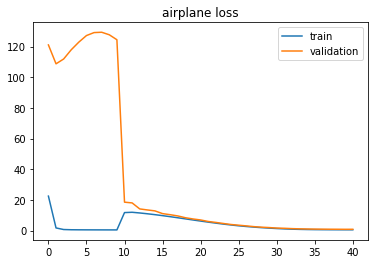

auc =  0.5728152222222223
[[ 822 8178]
 [ 113  887]]
Loading  automobile  data...


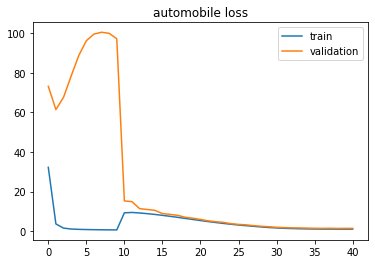

auc =  0.5709035
[[1653 7347]
 [  90  910]]
Loading  bird  data...


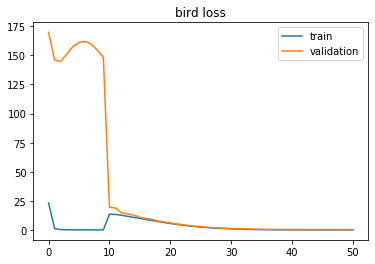

auc =  0.47710777777777774
[[ 482 8518]
 [  70  930]]
Loading  cat  data...


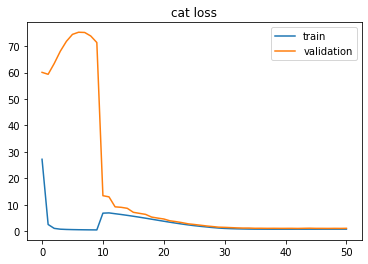

auc =  0.589545
[[1863 7137]
 [ 113  887]]
Loading  deer  data...


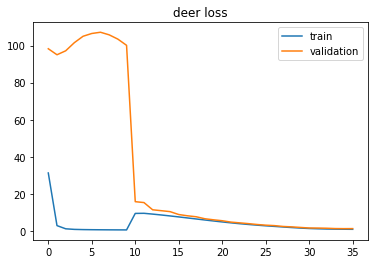

auc =  0.5581729444444444
[[1997 7003]
 [ 192  808]]
Loading  dog  data...


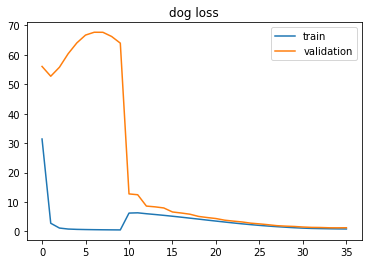

auc =  0.6159781111111111
[[2530 6470]
 [ 136  864]]
Loading  frog  data...


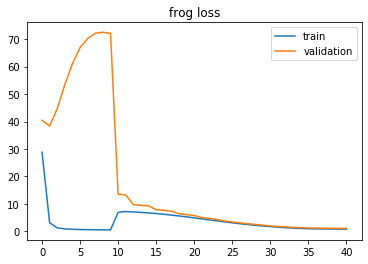

auc =  0.6056250555555556
[[2225 6775]
 [ 126  874]]
Loading  horse  data...


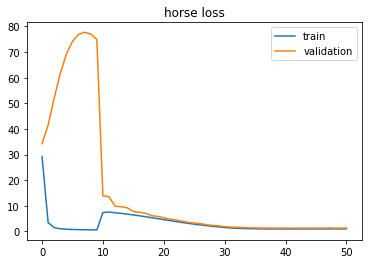

auc =  0.6015420555555555
[[2697 6303]
 [ 162  838]]
Loading  ship  data...


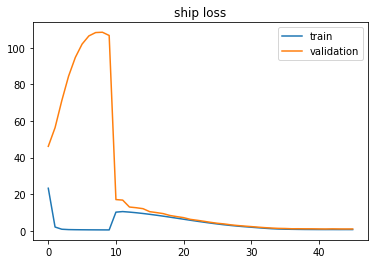

auc =  0.7609486111111112
[[2878 6122]
 [  91  909]]
Loading  truck  data...


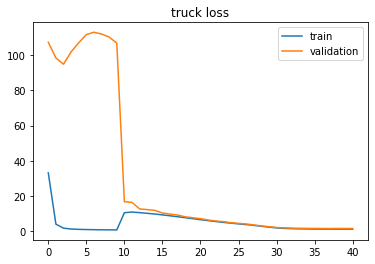

auc =  0.6846100555555555
[[2533 6467]
 [ 117  883]]


In [31]:
nu = 0.1
outlier_nu = 0.
smoothing = 3
warm_up_n_epochs = 10
lr_milestone = 13
lr_change = 0.25
label_list = []
auc_list = []
time_list = []
confusionmatrix_list = []
for label_num in np.arange(10):
    x_train, x_test, y_train, y_test = load_data(label_num = label_num, batch_size = 200, outlier_nu = outlier_nu)
    
    no_vali_dataset, train_dataset, x_vali_tensor, n_samples, validation_n = split_data(x_train)
    ## 利用validation data 決定訓練epoch
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(no_vali_dataset , encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, n_samples, validation_n,
                                     smoothing, warm_up_n_epochs, lr_milestone, lr_change)
    epoch_n = train_SVDD.valistation_train( no_vali_dataset, x_vali_tensor)
    ## 利用train data 訓練所有資料
    pre_time = time.time()
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(train_dataset , encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, n_samples, validation_n,
                                     smoothing, warm_up_n_epochs, lr_milestone, lr_change)
    train_SVDD.last_train(train_dataset, epoch_n)
    ## 訓練結果
    test_auc, confusionmatrix = train_SVDD.test_result(x_test, y_test, load_model = True)
    print('auc = ', test_auc)
    print(confusionmatrix)
    train_time = time.time() - pre_time
    label_list.append(label_num)
    auc_list.append(test_auc)
    time_list.append(train_time)
    confusionmatrix_list.append(confusionmatrix)


Loading  airplane  data...


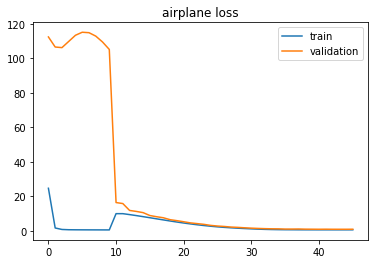

auc =  0.5815590555555556
[[ 632 8368]
 [ 100  900]]
Loading  automobile  data...


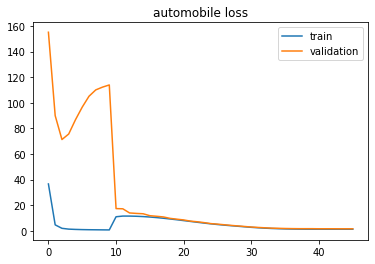

auc =  0.6036842222222222
[[2411 6589]
 [ 143  857]]
Loading  bird  data...


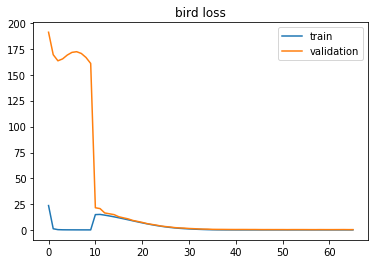

auc =  0.4763354444444444
[[ 780 8220]
 [ 115  885]]
Loading  cat  data...


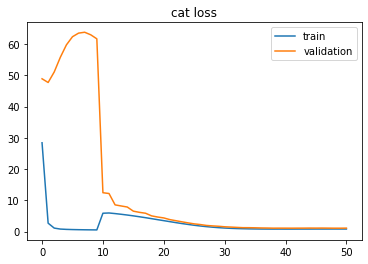

auc =  0.6150708333333333
[[2606 6394]
 [ 160  840]]
Loading  deer  data...


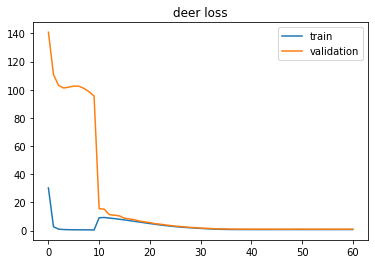

auc =  0.5317816111111111
[[1512 7488]
 [ 151  849]]
Loading  dog  data...


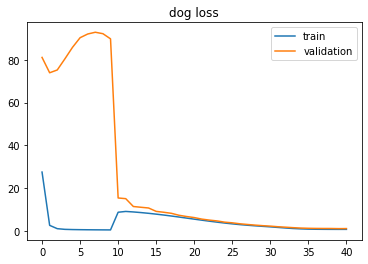

auc =  0.6493977222222223
[[1919 7081]
 [  98  902]]
Loading  frog  data...


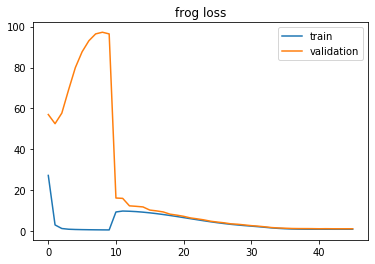

auc =  0.5908897777777777
[[2214 6786]
 [ 130  870]]
Loading  horse  data...


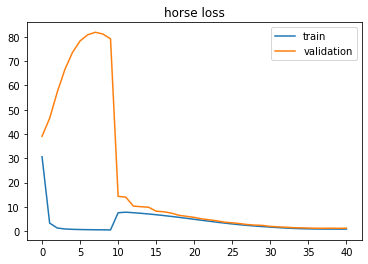

auc =  0.592156888888889
[[2192 6808]
 [ 126  874]]
Loading  ship  data...


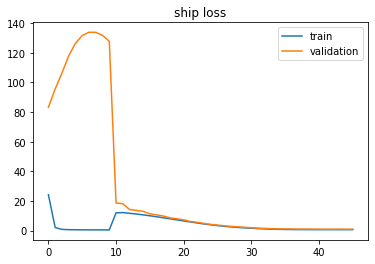

auc =  0.7550153888888889
[[3843 5157]
 [ 146  854]]
Loading  truck  data...


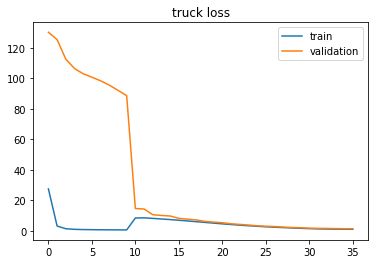

auc =  0.6765962222222222
[[2236 6764]
 [  88  912]]


In [30]:
nu = 0.1
outlier_nu = 0.
smoothing = 3
warm_up_n_epochs = 10
lr_milestone = 13
lr_change = 0.1
label_list = []
auc_list = []
time_list = []
confusionmatrix_list = []
for label_num in np.arange(10):
    x_train, x_test, y_train, y_test = load_data(label_num = label_num, batch_size = 200, outlier_nu = outlier_nu)
    
    no_vali_dataset, train_dataset, x_vali_tensor, n_samples, validation_n = split_data(x_train)
    ## 利用validation data 決定訓練epoch
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(no_vali_dataset , encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, n_samples, validation_n,
                                     smoothing, warm_up_n_epochs, lr_milestone, lr_change)
    epoch_n = train_SVDD.valistation_train( no_vali_dataset, x_vali_tensor)
    ## 利用train data 訓練所有資料
    pre_time = time.time()
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(train_dataset , encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, n_samples, validation_n,
                                     smoothing, warm_up_n_epochs, lr_milestone, lr_change)
    train_SVDD.last_train(train_dataset, epoch_n)
    ## 訓練結果
    test_auc, confusionmatrix = train_SVDD.test_result(x_test, y_test, load_model = True)
    print('auc = ', test_auc)
    print(confusionmatrix)
    train_time = time.time() - pre_time
    label_list.append(label_num)
    auc_list.append(test_auc)
    time_list.append(train_time)
    confusionmatrix_list.append(confusionmatrix)


Loading  airplane  data...


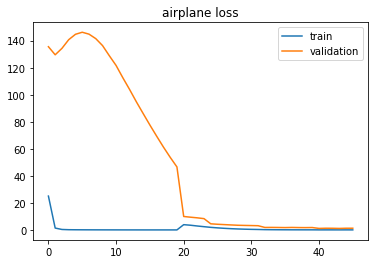

auc =  0.5795618333333333
[[ 738 8262]
 [  98  902]]
Loading  automobile  data...


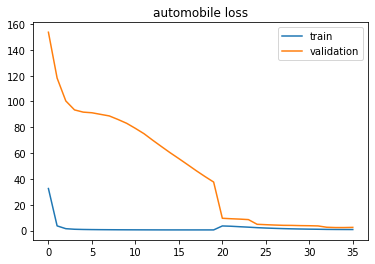

auc =  0.5904880555555556
[[2378 6622]
 [ 137  863]]
Loading  bird  data...


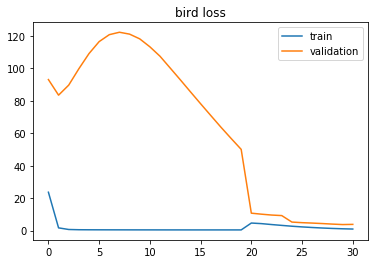

auc =  0.5092131111111111
[[ 596 8404]
 [  74  926]]
Loading  cat  data...


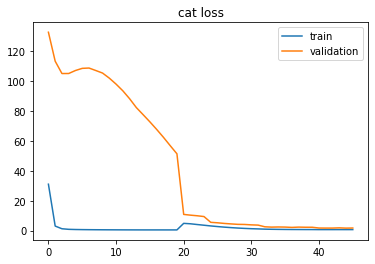

auc =  0.6265801666666666
[[2239 6761]
 [ 110  890]]
Loading  deer  data...


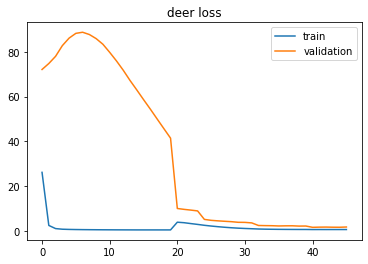

auc =  0.5387375555555556
[[1569 7431]
 [ 157  843]]
Loading  dog  data...


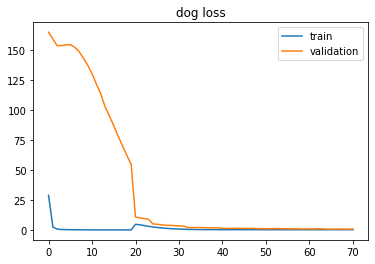

auc =  0.6711026666666665
[[2559 6441]
 [ 108  892]]
Loading  frog  data...


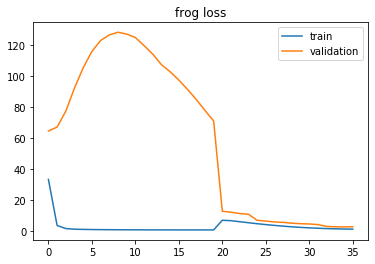

auc =  0.5780914444444445
[[2239 6761]
 [ 158  842]]
Loading  horse  data...


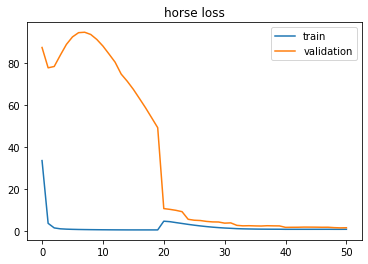

auc =  0.6072331666666666
[[2781 6219]
 [ 168  832]]
Loading  ship  data...


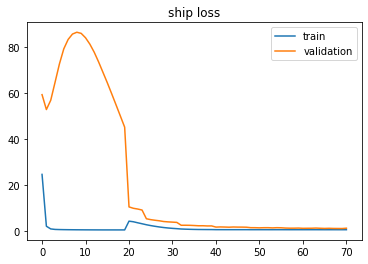

auc =  0.7447884444444444
[[2995 6005]
 [ 107  893]]
Loading  truck  data...


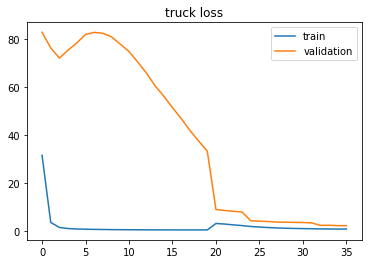

auc =  0.6836307222222222
[[2704 6296]
 [ 122  878]]


In [103]:
nu = 0.1
outlier_nu = 0.
smoothing = 8
warm_up_n_epochs = 20
lr_milestone = 15
lr_change = 0.1
label_list = []
auc_list = []
time_list = []
confusionmatrix_list = []
for label_num in np.arange(10):
    x_train, x_test, y_train, y_test = load_data(label_num = label_num, batch_size = 200, outlier_nu = outlier_nu)
    
    no_vali_dataset, train_dataset, x_vali_tensor, n_samples, validation_n = split_data(x_train)
    ## 利用validation data 決定訓練epoch
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(no_vali_dataset , encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, n_samples, validation_n,
                                     smoothing, warm_up_n_epochs, lr_milestone, lr_change)
    epoch_n = train_SVDD.valistation_train( no_vali_dataset, x_vali_tensor)
    ## 利用train data 訓練所有資料
    pre_time = time.time()
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(train_dataset , encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, n_samples, validation_n,
                                     smoothing, warm_up_n_epochs, lr_milestone, lr_change)
    train_SVDD.last_train(train_dataset, epoch_n)
    ## 訓練結果
    test_auc, confusionmatrix = train_SVDD.test_result(x_test, y_test, load_model = True)
    print('auc = ', test_auc)
    print(confusionmatrix)
    train_time = time.time() - pre_time
    label_list.append(label_num)
    auc_list.append(test_auc)
    time_list.append(train_time)
    confusionmatrix_list.append(confusionmatrix)


In [104]:
#outlier_nu = 0, nu = 0.1, smoothing = 8, warm_up_n_epochs = 20, lr_milestone = 15, lr_change = 0.1
for i in range(len(names)):
    print('label = ', names[i])
    print('auc = ', auc_list[i])
    print('time = ', time_list[i])
    print(confusionmatrix_list[i])

label =  airplane
auc =  0.5795618333333333
time =  29.203681707382202
[[ 738 8262]
 [  98  902]]
label =  automobile
auc =  0.5904880555555556
time =  19.742129802703857
[[2378 6622]
 [ 137  863]]
label =  bird
auc =  0.5092131111111111
time =  15.760966300964355
[[ 596 8404]
 [  74  926]]
label =  cat
auc =  0.6265801666666666
time =  27.65971541404724
[[2239 6761]
 [ 110  890]]
label =  deer
auc =  0.5387375555555556
time =  27.516135215759277
[[1569 7431]
 [ 157  843]]
label =  dog
auc =  0.6711026666666665
time =  48.4070041179657
[[2559 6441]
 [ 108  892]]
label =  frog
auc =  0.5780914444444445
time =  19.6604266166687
[[2239 6761]
 [ 158  842]]
label =  horse
auc =  0.6072331666666666
time =  31.729788303375244
[[2781 6219]
 [ 168  832]]
label =  ship
auc =  0.7447884444444444
time =  48.407039642333984
[[2995 6005]
 [ 107  893]]
label =  truck
auc =  0.6836307222222222
time =  19.904979467391968
[[2704 6296]
 [ 122  878]]


Loading  airplane  data...


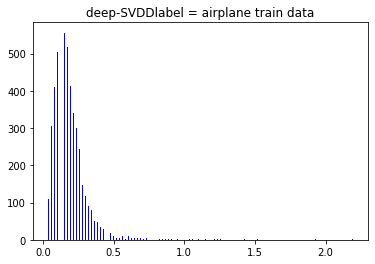

 train label = airplane uncertain_img


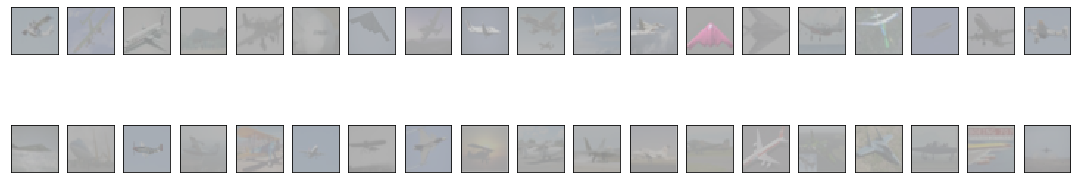

train label = 0 distance oder


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


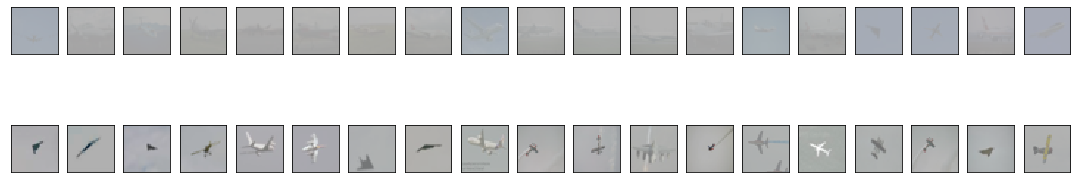

train label = airplane false_img


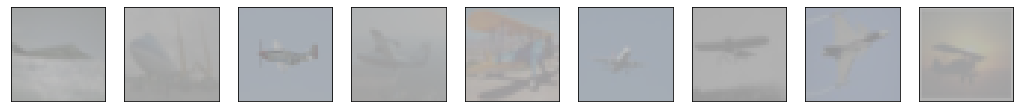

AUC: 0.5795618333333333
confusion_matrix:
[[ 738 8262]
 [  98  902]]


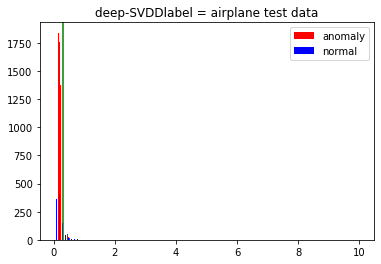

test label = airplane uncertain_img


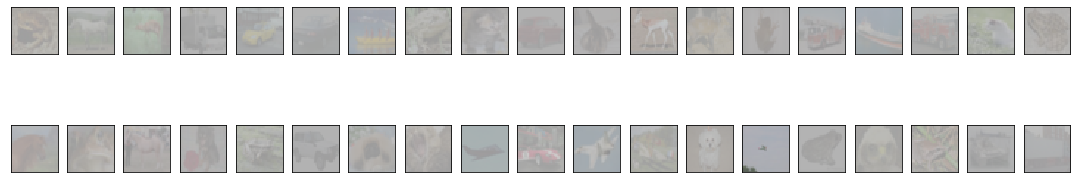

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test label = airplane distance oder


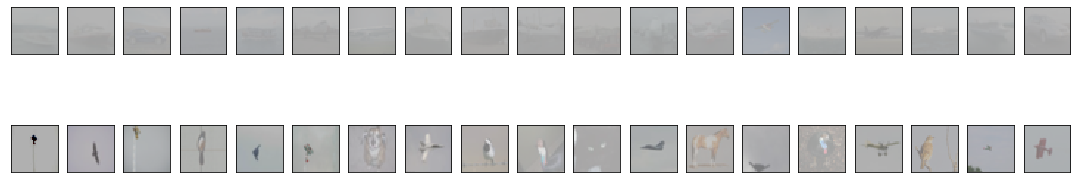

test label = airplane false_img


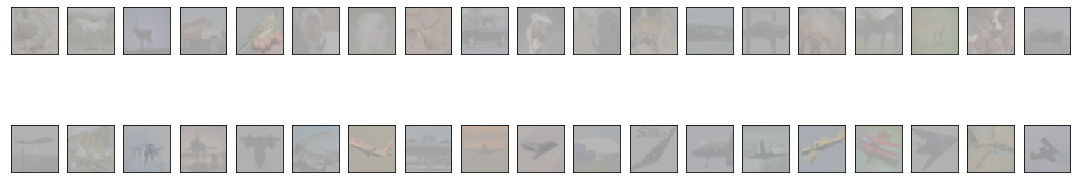

Loading  automobile  data...


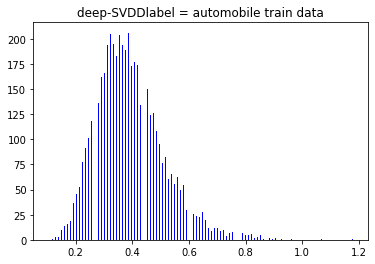

 train label = automobile uncertain_img


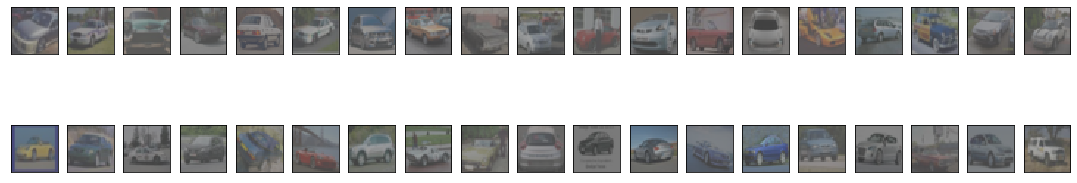

train label = 1 distance oder


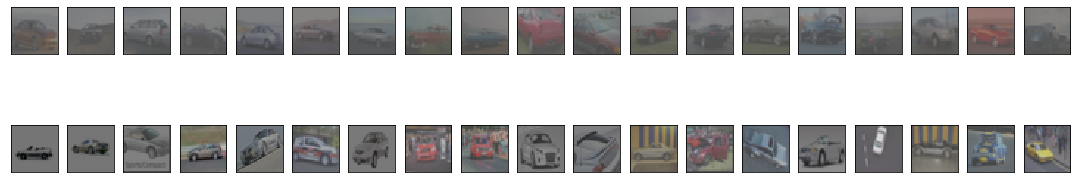

train label = automobile false_img


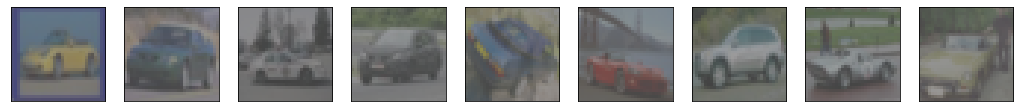

AUC: 0.5904880555555556
confusion_matrix:
[[2378 6622]
 [ 137  863]]


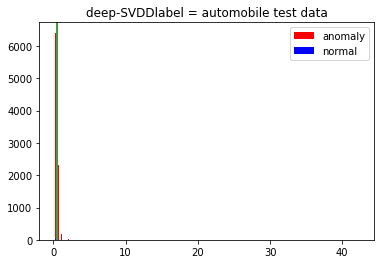

test label = automobile uncertain_img


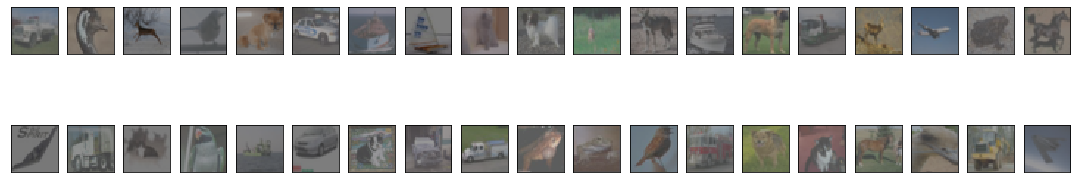

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test label = automobile distance oder


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

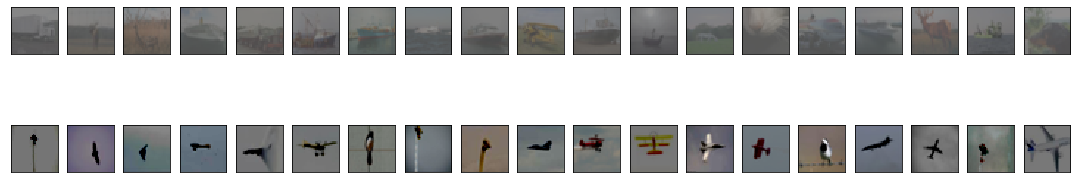

test label = automobile false_img


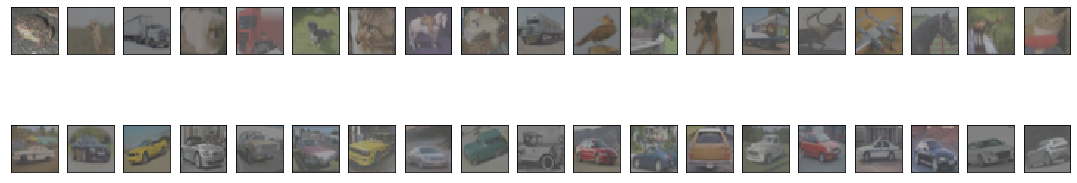

Loading  bird  data...


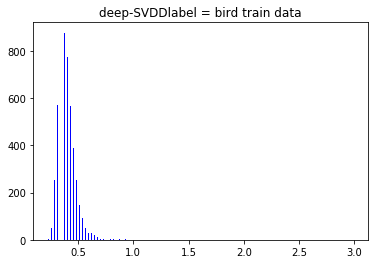

 train label = bird uncertain_img


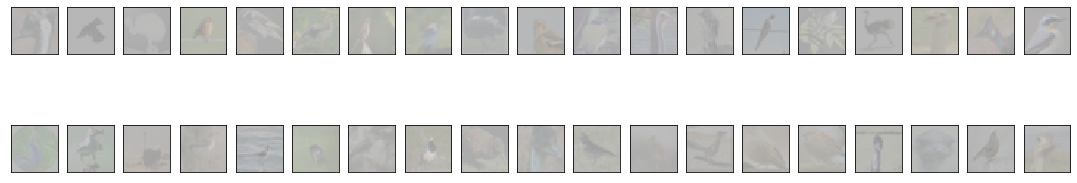

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train label = 2 distance oder


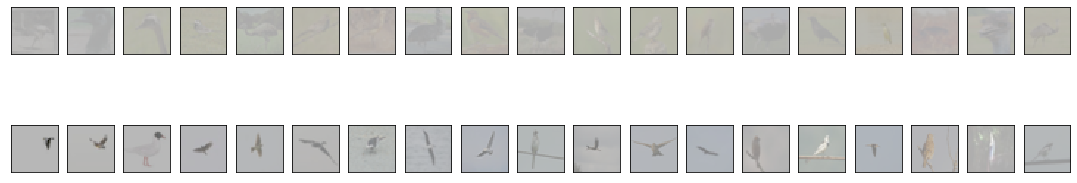

train label = bird false_img


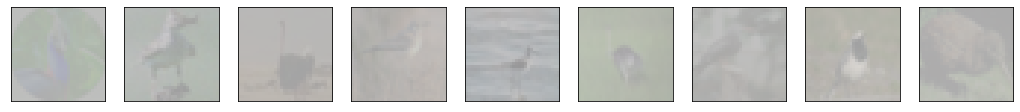

AUC: 0.5092131111111111
confusion_matrix:
[[ 596 8404]
 [  74  926]]


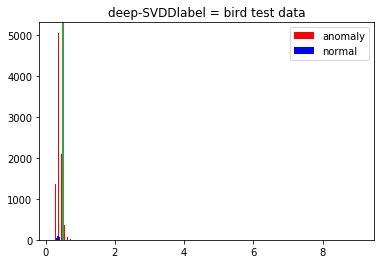

test label = bird uncertain_img


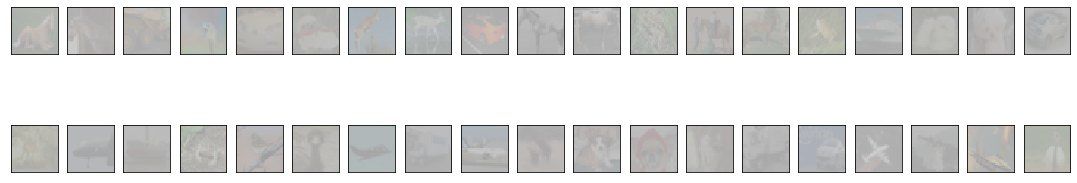

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test label = bird distance oder


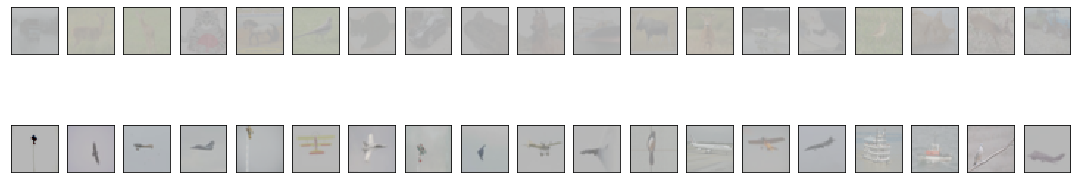

test label = bird false_img


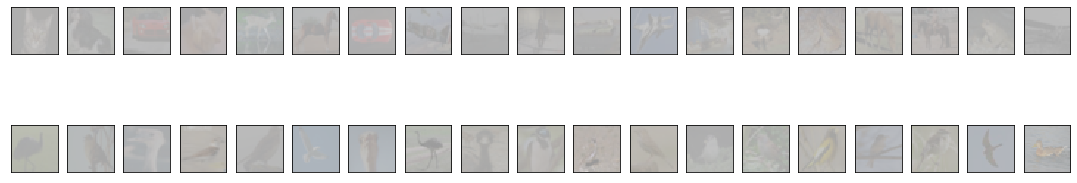

Loading  cat  data...


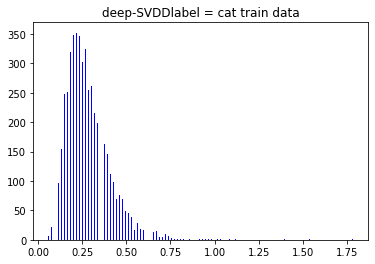

 train label = cat uncertain_img


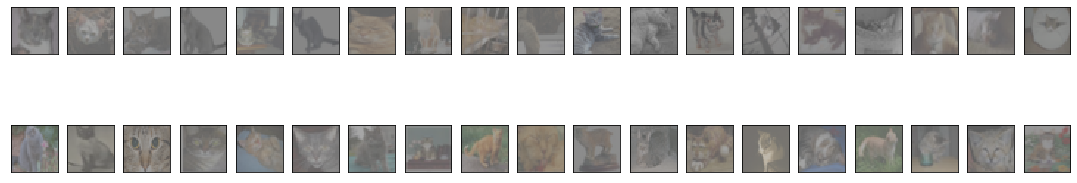

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train label = 3 distance oder


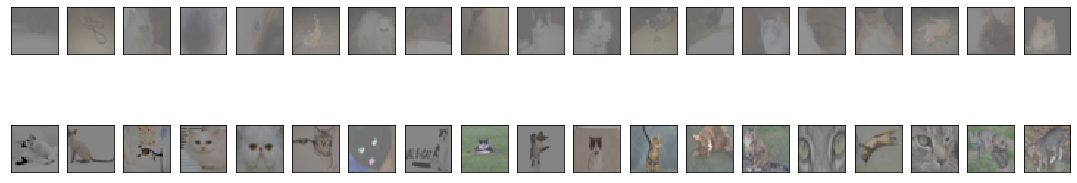

train label = cat false_img


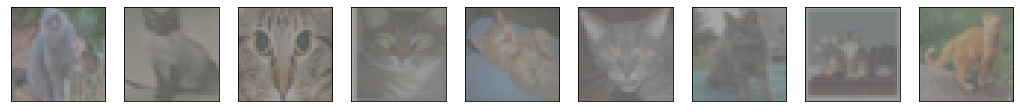

AUC: 0.6265801666666666
confusion_matrix:
[[2239 6761]
 [ 110  890]]


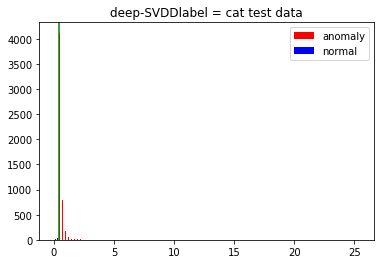

test label = cat uncertain_img


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


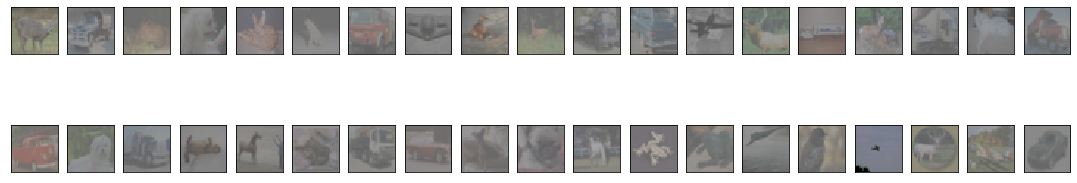

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test label = cat distance oder


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


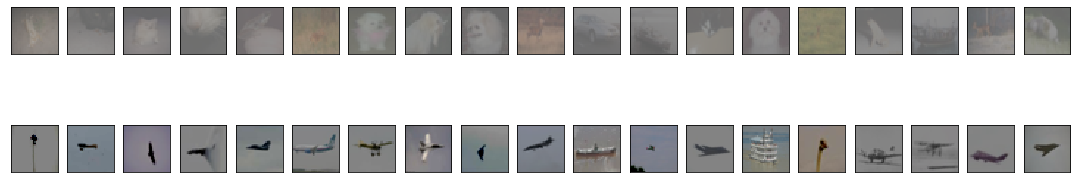

test label = cat false_img


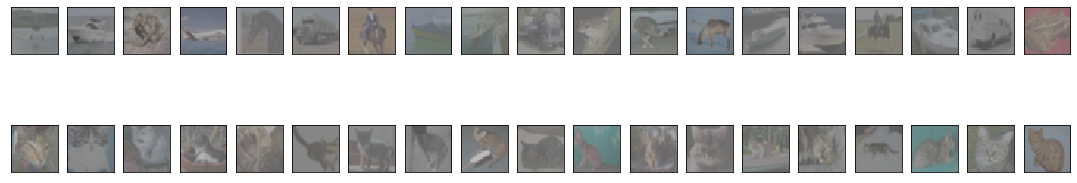

Loading  deer  data...


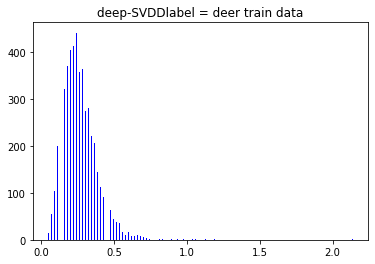

 train label = deer uncertain_img


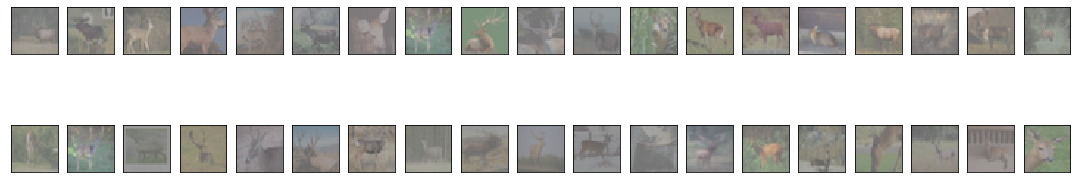

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train label = 4 distance oder


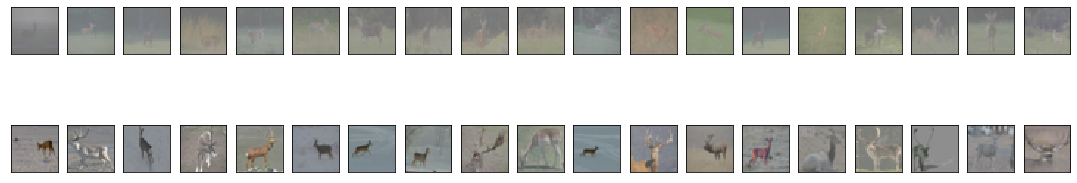

train label = deer false_img


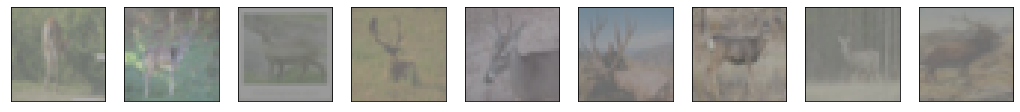

AUC: 0.5387375555555556
confusion_matrix:
[[1569 7431]
 [ 157  843]]


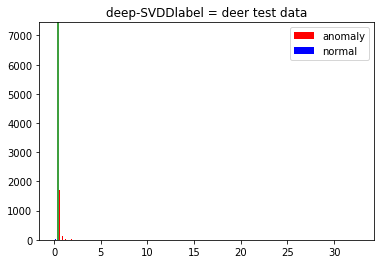

test label = deer uncertain_img


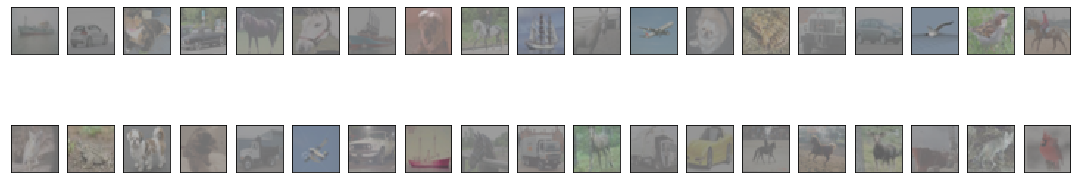

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test label = deer distance oder


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


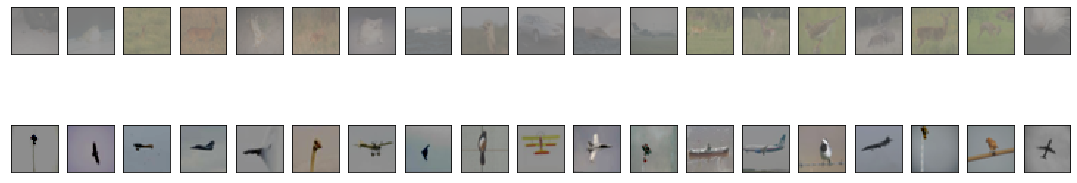

test label = deer false_img


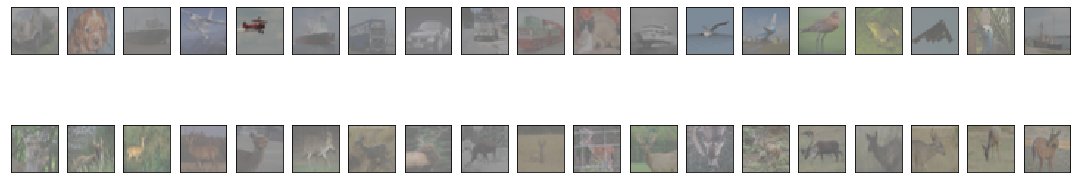

Loading  dog  data...


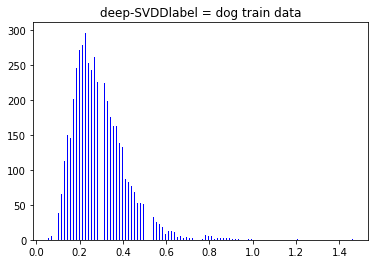

 train label = dog uncertain_img


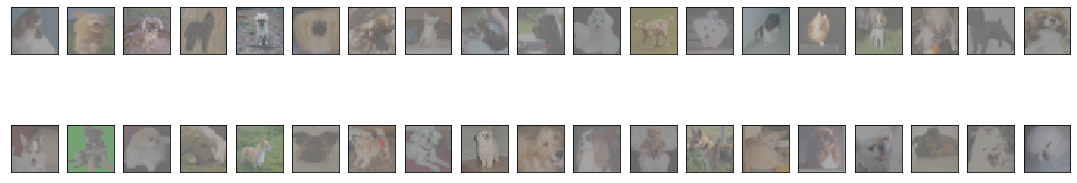

train label = 5 distance oder


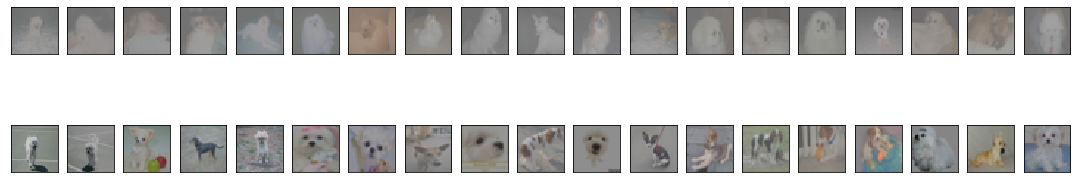

train label = dog false_img


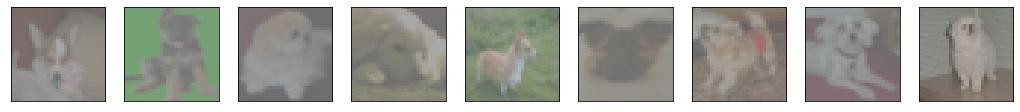

AUC: 0.6711026666666665
confusion_matrix:
[[2559 6441]
 [ 108  892]]


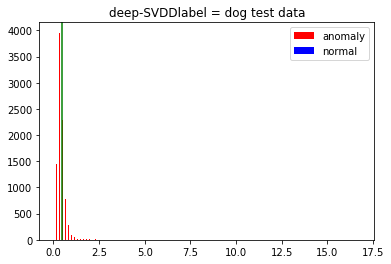

test label = dog uncertain_img


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


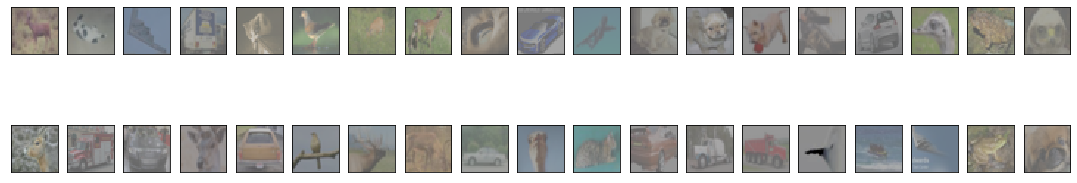

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test label = dog distance oder


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


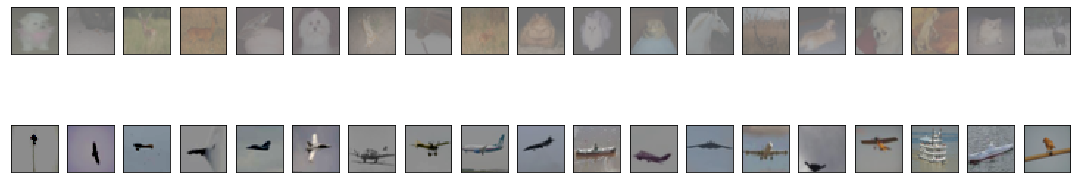

test label = dog false_img


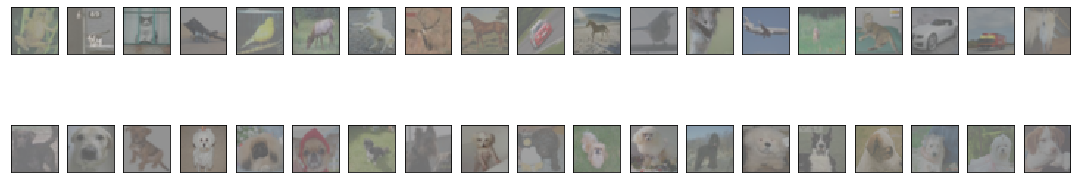

Loading  frog  data...


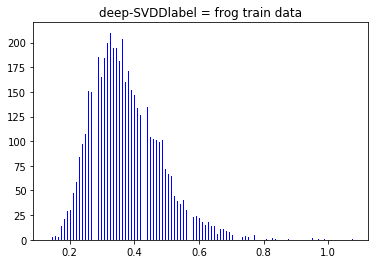

 train label = frog uncertain_img


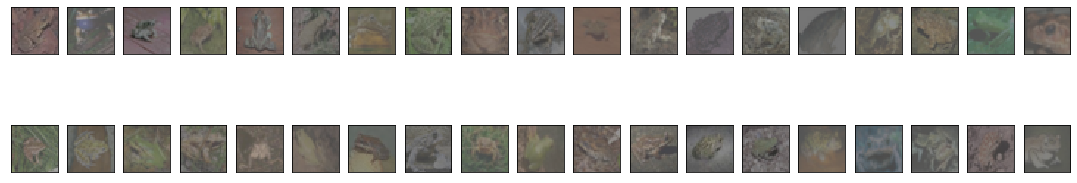

train label = 6 distance oder


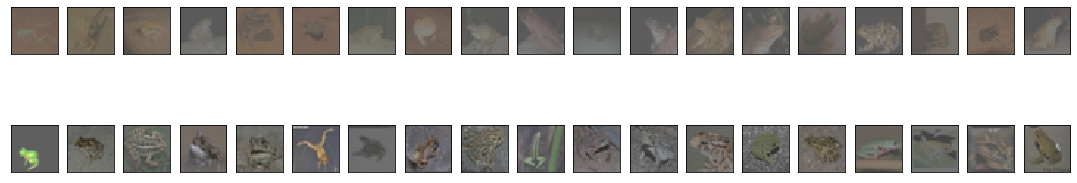

train label = frog false_img


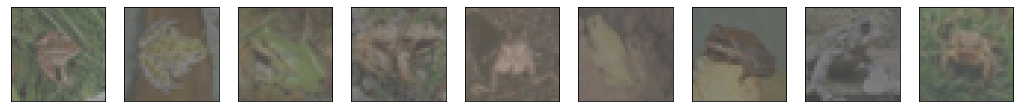

AUC: 0.5780914444444445
confusion_matrix:
[[2239 6761]
 [ 158  842]]


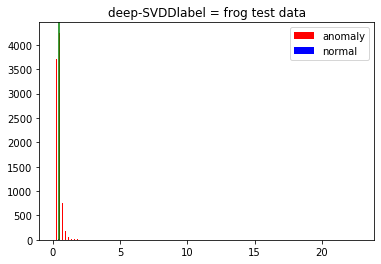

test label = frog uncertain_img


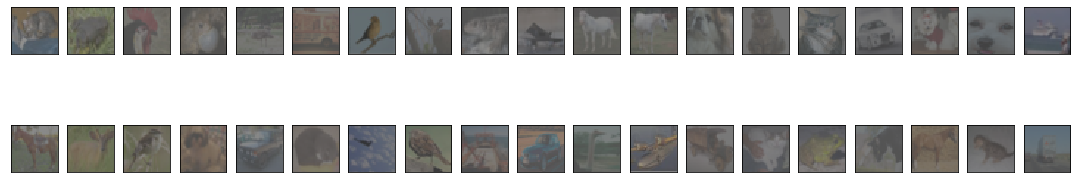

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test label = frog distance oder


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


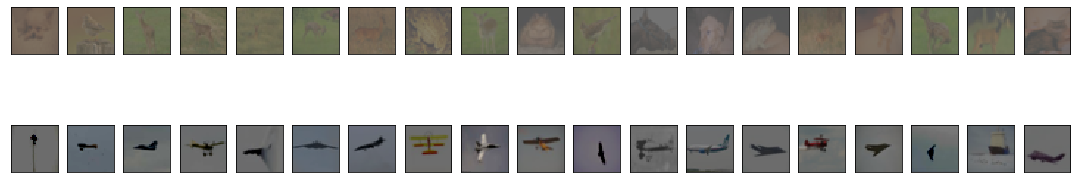

test label = frog false_img


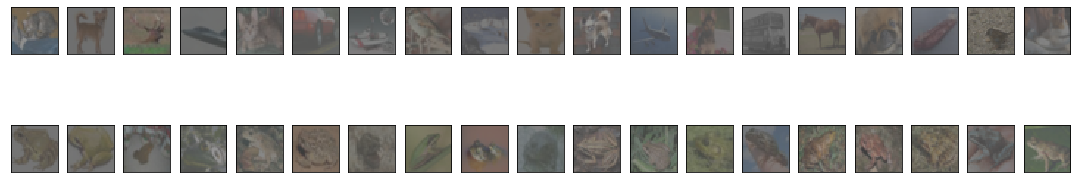

Loading  horse  data...


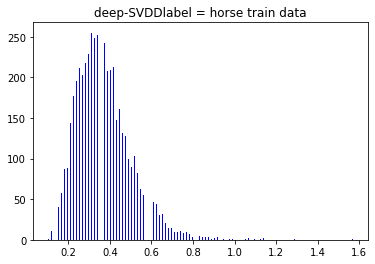

 train label = horse uncertain_img


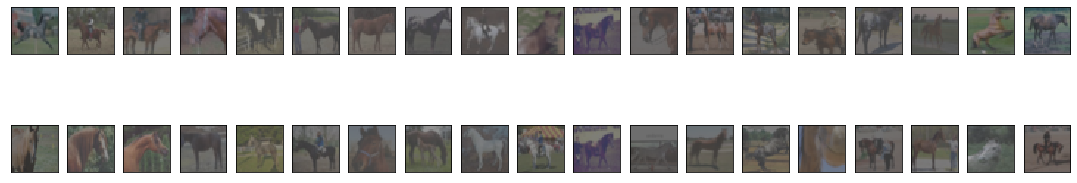

train label = 7 distance oder


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


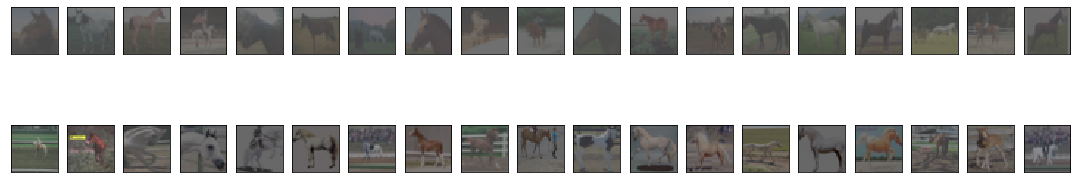

train label = horse false_img


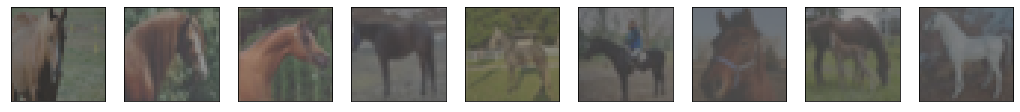

AUC: 0.6072331666666666
confusion_matrix:
[[2781 6219]
 [ 168  832]]


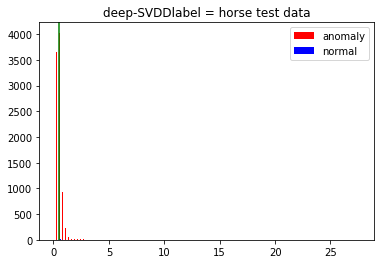

test label = horse uncertain_img


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


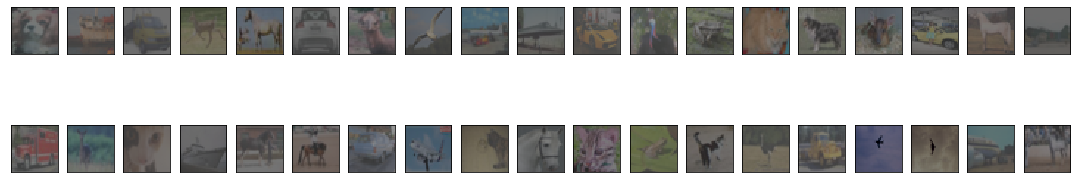

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test label = horse distance oder


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


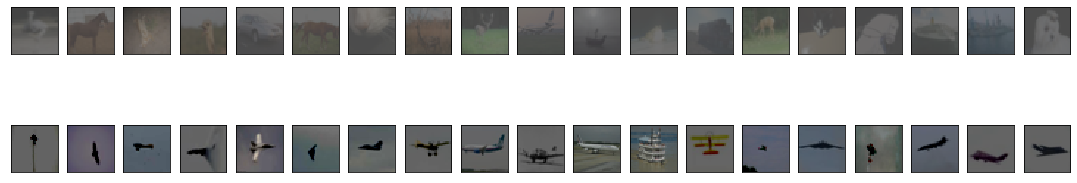

test label = horse false_img


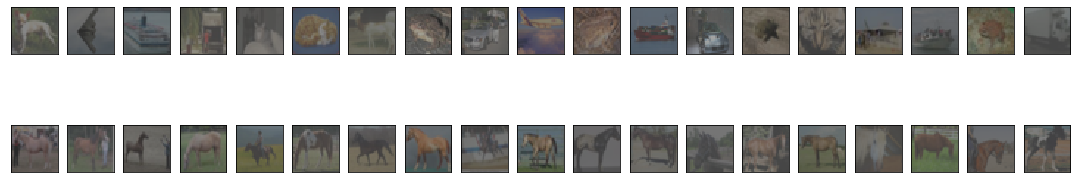

Loading  ship  data...


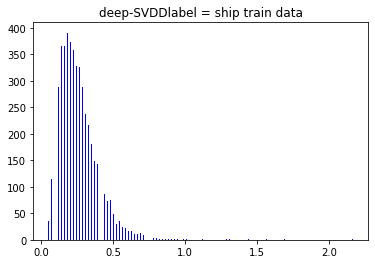

 train label = ship uncertain_img


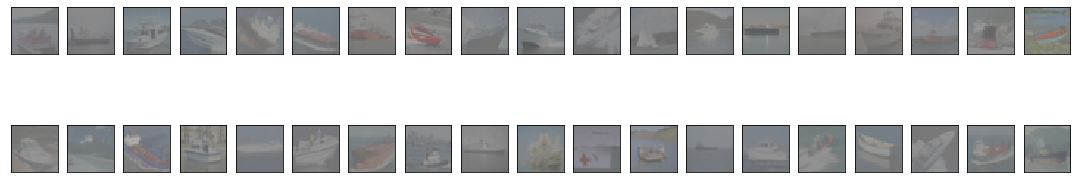

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train label = 8 distance oder


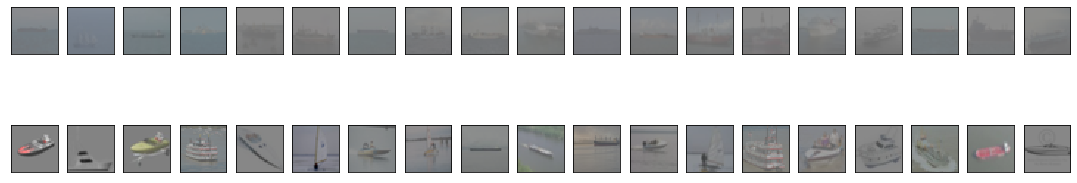

train label = ship false_img


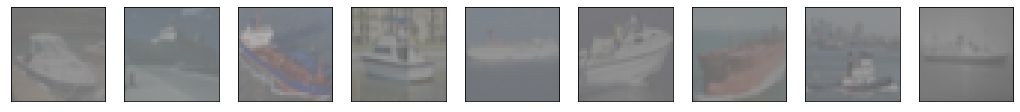

AUC: 0.7447884444444444
confusion_matrix:
[[2995 6005]
 [ 107  893]]


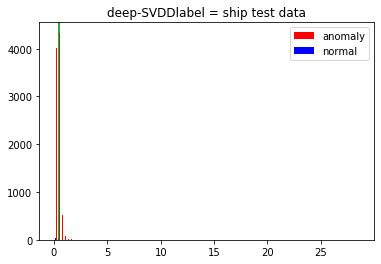

test label = ship uncertain_img


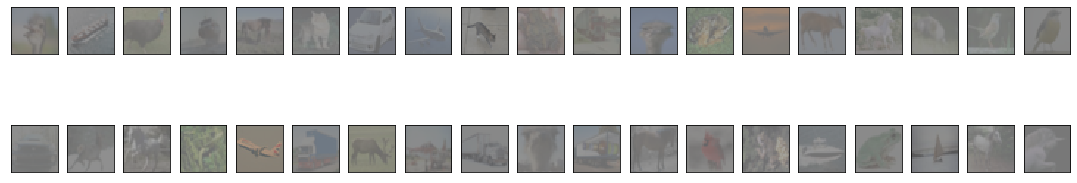

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test label = ship distance oder


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


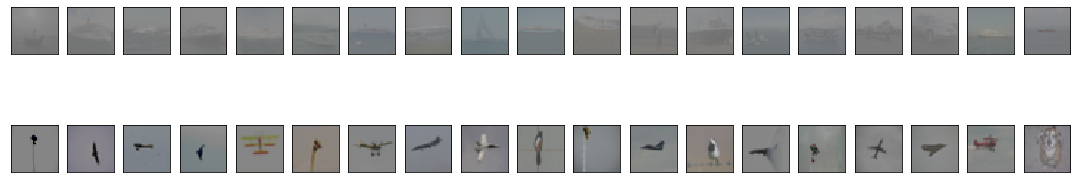

test label = ship false_img


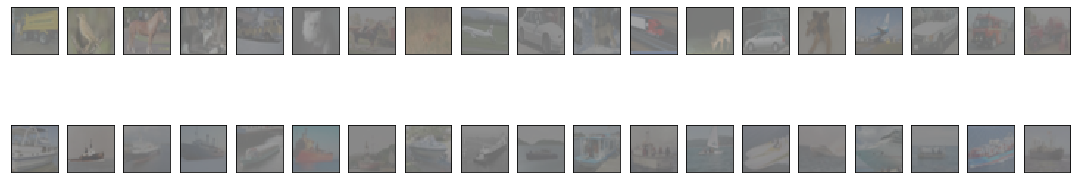

Loading  truck  data...


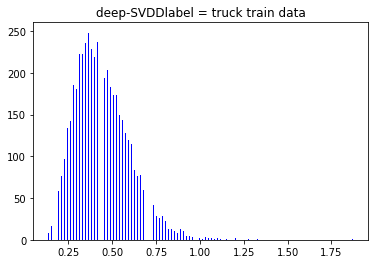

 train label = truck uncertain_img


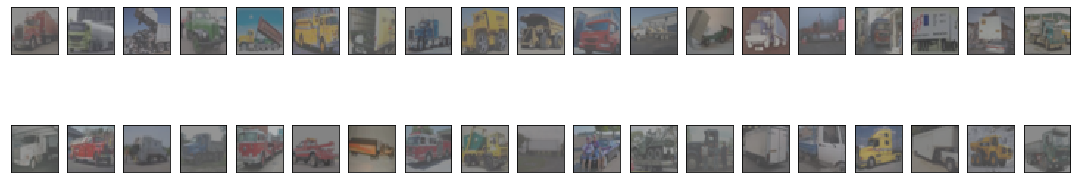

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train label = 9 distance oder


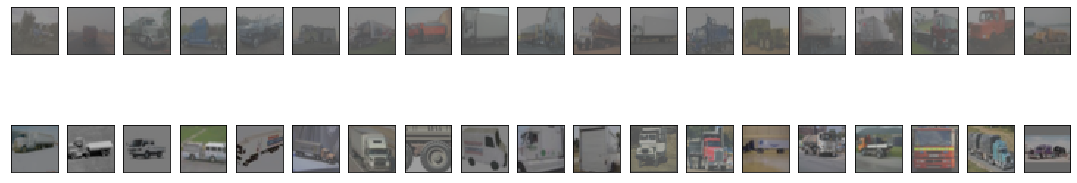

train label = truck false_img


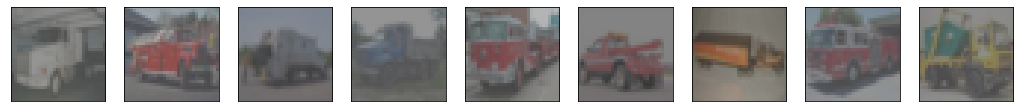

AUC: 0.6836307222222222
confusion_matrix:
[[2704 6296]
 [ 122  878]]


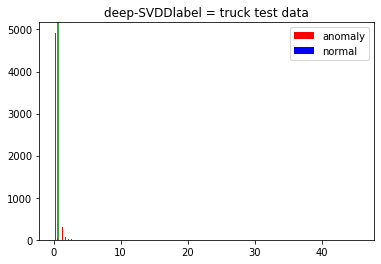

test label = truck uncertain_img


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


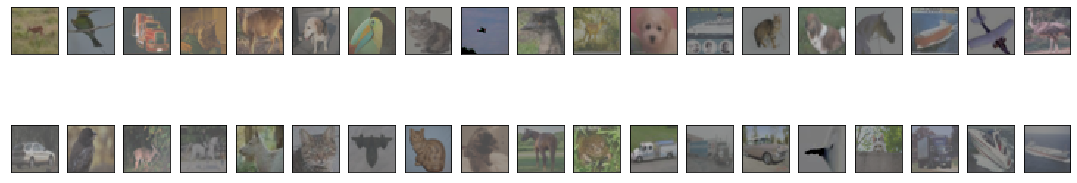

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test label = truck distance oder


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

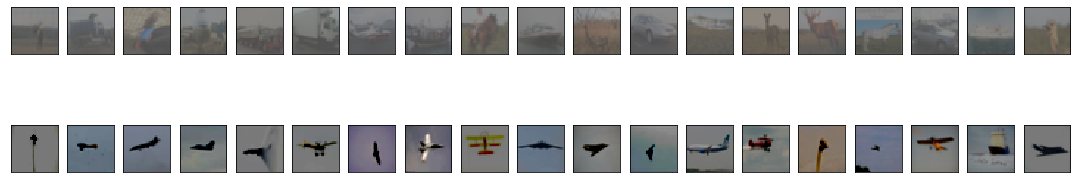

test label = truck false_img


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


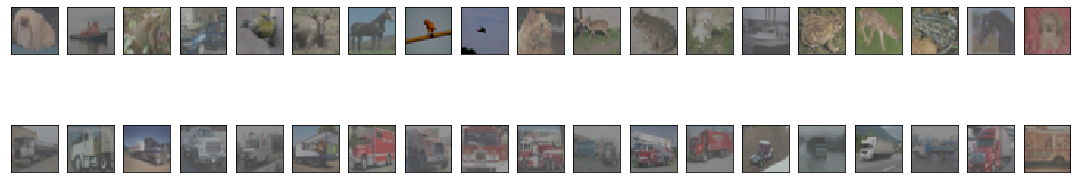

In [113]:
for label_num in np.arange(10):
    
    x_train, x_test, y_train, y_test = load_data(label_num = label_num, batch_size = 200, outlier_nu = outlier_nu)
    
    no_vali_dataset, train_dataset, x_vali_tensor, n_samples, validation_n = split_data(x_train)
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(train_dataset , encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, n_samples, validation_n,
                                     smoothing, warm_up_n_epochs, lr_milestone, lr_change)
    train_SVDD.train_result( x_train, y_train, load_model = True, show_img = True)
    test_auc, confusionmatrix = train_SVDD.test_result(x_test, y_test, load_model = True, show_img = True)


## outlier = 0.3

Loading  airplane  data...


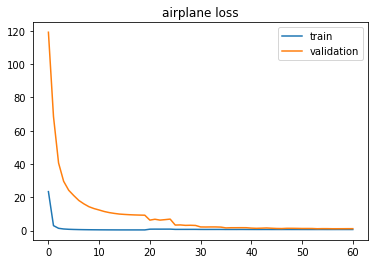

auc =  0.6034841666666667
[[1599 7401]
 [ 100  900]]
Loading  automobile  data...


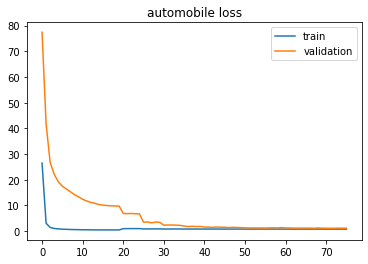

auc =  0.4587513888888889
[[1684 7316]
 [ 136  864]]
Loading  bird  data...


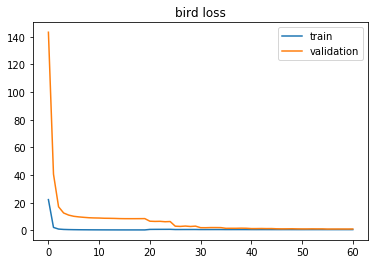

auc =  0.641645888888889
[[2642 6358]
 [ 156  844]]
Loading  cat  data...


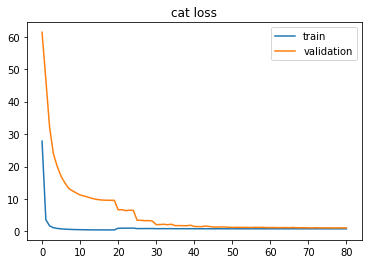

auc =  0.47822833333333337
[[1311 7689]
 [ 143  857]]
Loading  deer  data...


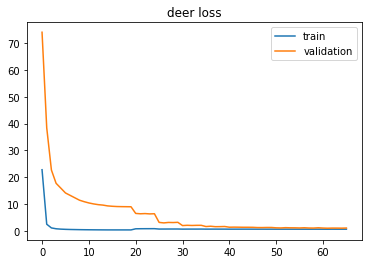

auc =  0.7088101666666666
[[2403 6597]
 [  75  925]]
Loading  dog  data...


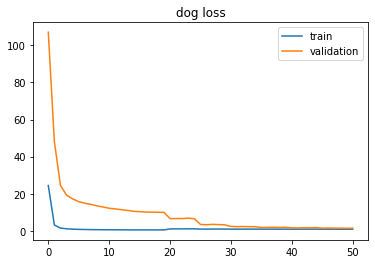

auc =  0.47669355555555554
[[ 898 8102]
 [  82  918]]
Loading  frog  data...


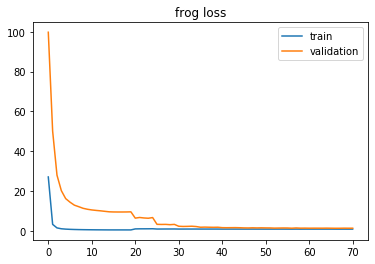

auc =  0.7062898888888889
[[2570 6430]
 [  70  930]]
Loading  horse  data...


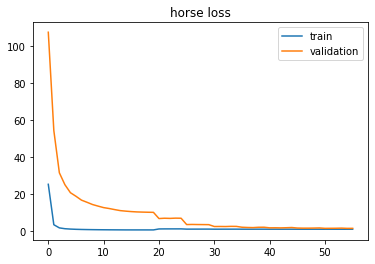

auc =  0.48308383333333327
[[ 955 8045]
 [  81  919]]
Loading  ship  data...


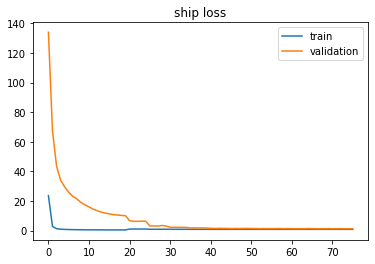

auc =  0.6592218888888889
[[ 956 8044]
 [  32  968]]
Loading  truck  data...


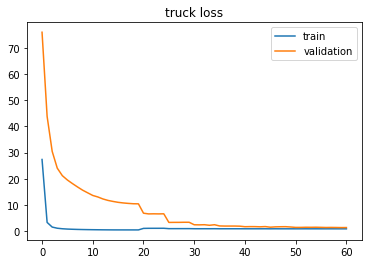

auc =  0.5352808888888889
[[1577 7423]
 [  93  907]]


In [16]:
nu = 0.1
outlier_nu = 0.1

smoothing = 5
warm_up_n_epochs = 20
lr_milestone = 15
lr_change = 0.1
label_list = []
auc_list = []
time_list = []
confusionmatrix_list = []
for label_num in np.arange(10):
    x_train, x_test, y_train, y_test = load_notransform_data(label_num = label_num, batch_size = 200, outlier_nu = outlier_nu)
    
    no_vali_dataset, train_dataset, x_vali_tensor, n_samples, validation_n = split_data(x_train)
    ## 利用validation data 決定訓練epoch
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(no_vali_dataset , encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, n_samples, validation_n,
                                     smoothing, warm_up_n_epochs, lr_milestone, lr_change)
    epoch_n = train_SVDD.valistation_train( no_vali_dataset, x_vali_tensor)
    ## 利用train data 訓練所有資料
    pre_time = time.time()
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(train_dataset , encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, n_samples, validation_n,
                                     smoothing, warm_up_n_epochs, lr_milestone, lr_change)
    train_SVDD.last_train(train_dataset, epoch_n)
    ## 訓練結果
    test_auc, confusionmatrix = train_SVDD.test_result(x_test, y_test, load_model = True)
    print('auc = ', test_auc)
    print(confusionmatrix)
    train_time = time.time() - pre_time
    label_list.append(label_num)
    auc_list.append(test_auc)
    time_list.append(train_time)
    confusionmatrix_list.append(confusionmatrix)


In [17]:
#outlier_nu = 0.3, nu = 0.3, smoothing = 3, warm_up_n_epochs = 10, lr_milestone = 30, lr_change = 0.1
for i in range(len(names)):
    print('label = ', names[i])
    print('auc = ', auc_list[i])
    print('time = ', time_list[i])
    print(confusionmatrix_list[i])

label =  airplane
auc =  0.6034841666666667
time =  46.473315715789795
[[1599 7401]
 [ 100  900]]
label =  automobile
auc =  0.4587513888888889
time =  60.417179346084595
[[1684 7316]
 [ 136  864]]
label =  bird
auc =  0.641645888888889
time =  46.10819983482361
[[2642 6358]
 [ 156  844]]
label =  cat
auc =  0.47822833333333337
time =  66.09089231491089
[[1311 7689]
 [ 143  857]]
label =  deer
auc =  0.7088101666666666
time =  53.012585401535034
[[2403 6597]
 [  75  925]]
label =  dog
auc =  0.47669355555555554
time =  37.94365167617798
[[ 898 8102]
 [  82  918]]
label =  frog
auc =  0.7062898888888889
time =  57.4401478767395
[[2570 6430]
 [  70  930]]
label =  horse
auc =  0.48308383333333327
time =  42.6937894821167
[[ 955 8045]
 [  81  919]]
label =  ship
auc =  0.6592218888888889
time =  61.9003963470459
[[ 956 8044]
 [  32  968]]
label =  truck
auc =  0.5352808888888889
time =  46.15228748321533
[[1577 7423]
 [  93  907]]


Loading  airplane  data...


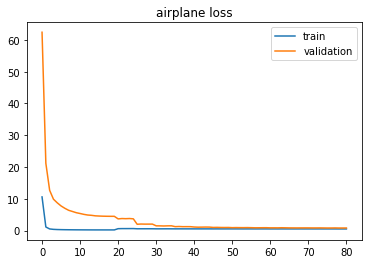

auc =  0.5998041666666667
[[2371 6629]
 [ 127  873]]
Loading  automobile  data...


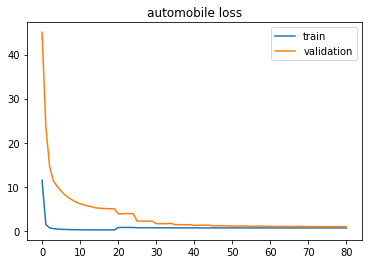

auc =  0.4366172222222222
[[1973 7027]
 [ 200  800]]
Loading  bird  data...


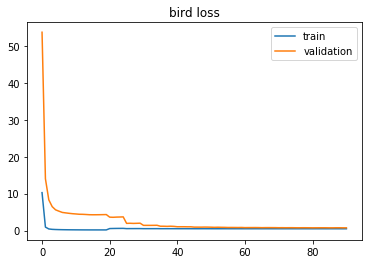

auc =  0.6546997777777779
[[2863 6137]
 [ 161  839]]
Loading  cat  data...


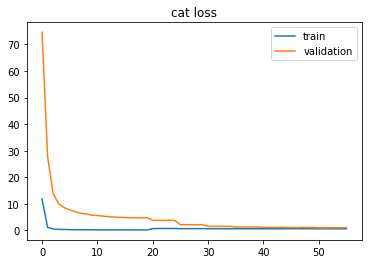

auc =  0.46846172222222227
[[1930 7070]
 [ 223  777]]
Loading  deer  data...


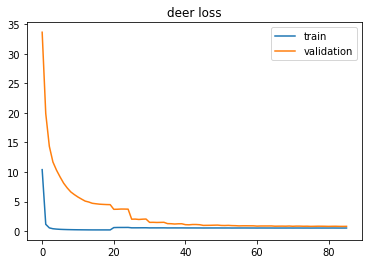

auc =  0.7181341666666667
[[2853 6147]
 [  95  905]]
Loading  dog  data...


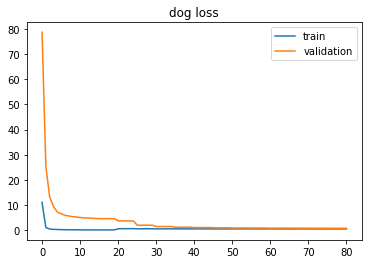

auc =  0.4756226666666667
[[1448 7552]
 [ 154  846]]
Loading  frog  data...


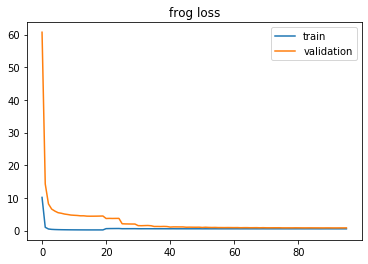

auc =  0.7121676666666666
[[2584 6416]
 [  74  926]]
Loading  horse  data...


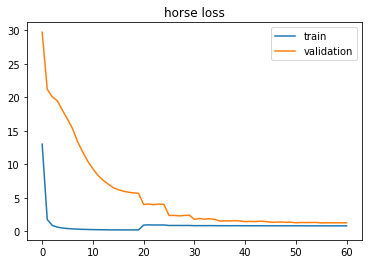

auc =  0.49104072222222217
[[2733 6267]
 [ 268  732]]
Loading  ship  data...


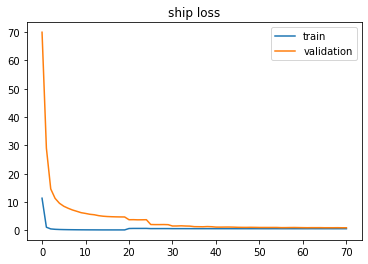

auc =  0.6040345555555555
[[2062 6938]
 [ 124  876]]
Loading  truck  data...


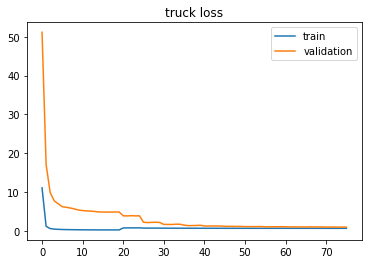

auc =  0.5136582777777777
[[2012 6988]
 [ 140  860]]


In [18]:
nu = 0.2
outlier_nu = 0.2

smoothing = 5
warm_up_n_epochs = 20
lr_milestone = 15
lr_change = 0.1
label_list = []
auc_list = []
time_list = []
confusionmatrix_list = []
for label_num in np.arange(10):
    x_train, x_test, y_train, y_test = load_notransform_data(label_num = label_num, batch_size = 200, outlier_nu = outlier_nu)
    
    no_vali_dataset, train_dataset, x_vali_tensor, n_samples, validation_n = split_data(x_train)
    ## 利用validation data 決定訓練epoch
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(no_vali_dataset , encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, n_samples, validation_n,
                                     smoothing, warm_up_n_epochs, lr_milestone, lr_change)
    epoch_n = train_SVDD.valistation_train( no_vali_dataset, x_vali_tensor)
    ## 利用train data 訓練所有資料
    pre_time = time.time()
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(train_dataset , encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, n_samples, validation_n,
                                     smoothing, warm_up_n_epochs, lr_milestone, lr_change)
    train_SVDD.last_train(train_dataset, epoch_n)
    ## 訓練結果
    test_auc, confusionmatrix = train_SVDD.test_result(x_test, y_test, load_model = True)
    print('auc = ', test_auc)
    print(confusionmatrix)
    train_time = time.time() - pre_time
    label_list.append(label_num)
    auc_list.append(test_auc)
    time_list.append(train_time)
    confusionmatrix_list.append(confusionmatrix)


In [19]:
#outlier_nu = 0.3, nu = 0.3, smoothing = 3, warm_up_n_epochs = 10, lr_milestone = 30, lr_change = 0.1
for i in range(len(names)):
    print('label = ', names[i])
    print('auc = ', auc_list[i])
    print('time = ', time_list[i])
    print(confusionmatrix_list[i])

label =  airplane
auc =  0.5998041666666667
time =  66.73664855957031
[[2371 6629]
 [ 127  873]]
label =  automobile
auc =  0.4366172222222222
time =  67.59090065956116
[[1973 7027]
 [ 200  800]]
label =  bird
auc =  0.6546997777777779
time =  86.88184833526611
[[2863 6137]
 [ 161  839]]
label =  cat
auc =  0.46846172222222227
time =  47.54398536682129
[[1930 7070]
 [ 223  777]]
label =  deer
auc =  0.7181341666666667
time =  75.10189938545227
[[2853 6147]
 [  95  905]]
label =  dog
auc =  0.4756226666666667
time =  71.50961232185364
[[1448 7552]
 [ 154  846]]
label =  frog
auc =  0.7121676666666666
time =  89.98378229141235
[[2584 6416]
 [  74  926]]
label =  horse
auc =  0.49104072222222217
time =  52.262779712677
[[2733 6267]
 [ 268  732]]
label =  ship
auc =  0.6040345555555555
time =  64.80720543861389
[[2062 6938]
 [ 124  876]]
label =  truck
auc =  0.5136582777777777
time =  68.00654411315918
[[2012 6988]
 [ 140  860]]


Loading  airplane  data...


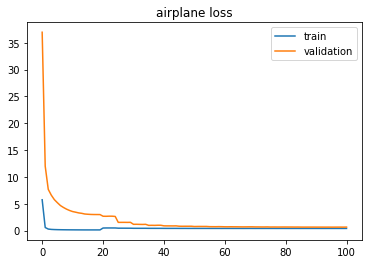

auc =  0.6497442222222223
[[3149 5851]
 [ 153  847]]
Loading  automobile  data...


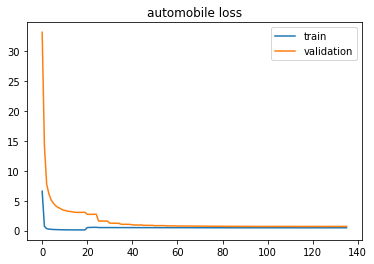

auc =  0.4298548333333333
[[3296 5704]
 [ 420  580]]
Loading  bird  data...


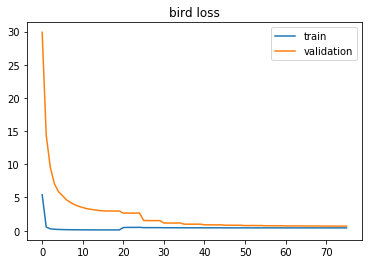

auc =  0.6429296111111111
[[3650 5350]
 [ 220  780]]
Loading  cat  data...


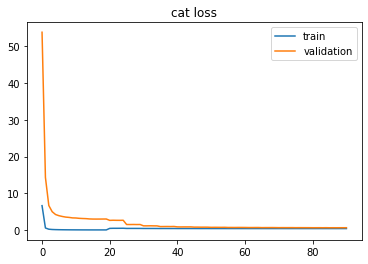

KeyboardInterrupt: 

In [25]:
nu = 0.3
outlier_nu = 0.3

smoothing = 5
warm_up_n_epochs = 20
lr_milestone = 15
lr_change = 0.1
label_list = []
auc_list = []
time_list = []
confusionmatrix_list = []
for label_num in np.arange(10):
    x_train, x_test, y_train, y_test = load_notransform_data(label_num = label_num, batch_size = 200, outlier_nu = outlier_nu)
    
    no_vali_dataset, train_dataset, x_vali_tensor, n_samples, validation_n = split_data(x_train)
    ## 利用validation data 決定訓練epoch
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(no_vali_dataset , encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, n_samples, validation_n,
                                     smoothing, warm_up_n_epochs, lr_milestone, lr_change)
    epoch_n = train_SVDD.valistation_train( no_vali_dataset, x_vali_tensor)
    ## 利用train data 訓練所有資料
    pre_time = time.time()
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(train_dataset , encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, n_samples, validation_n,
                                     smoothing, warm_up_n_epochs, lr_milestone, lr_change)
    train_SVDD.last_train(train_dataset, epoch_n)
    ## 訓練結果
    test_auc, confusionmatrix = train_SVDD.test_result(x_test, y_test, load_model = True)
    print('auc = ', test_auc)
    print(confusionmatrix)
    train_time = time.time() - pre_time
    label_list.append(label_num)
    auc_list.append(test_auc)
    time_list.append(train_time)
    confusionmatrix_list.append(confusionmatrix)


Loading  airplane  data...


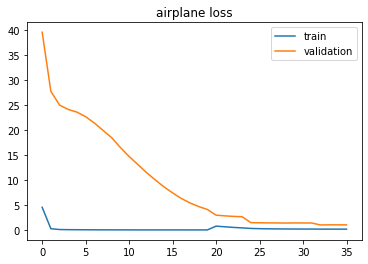

auc =  0.5419833333333333
[[   2 8998]
 [   3  997]]
Loading  automobile  data...


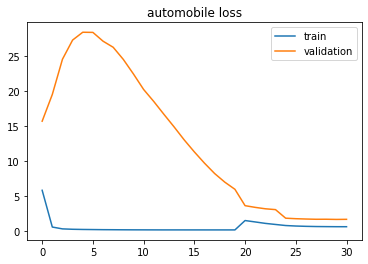

auc =  0.5640042222222222
[[6070 2930]
 [ 599  401]]
Loading  bird  data...


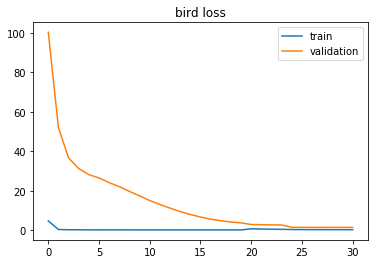

auc =  0.46712566666666666
[[   3 8997]
 [   1  999]]
Loading  cat  data...


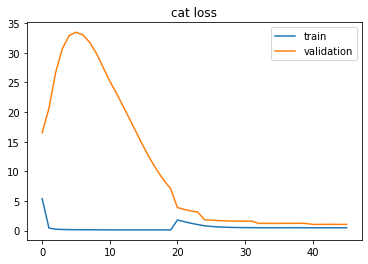

auc =  0.5952065
[[1986 7014]
 [ 123  877]]
Loading  deer  data...


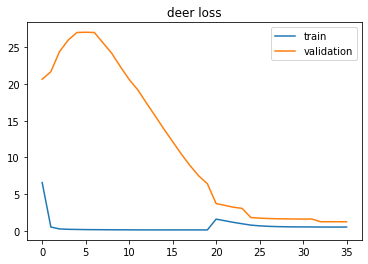

auc =  0.5127908333333334
[[ 754 8246]
 [  89  911]]
Loading  dog  data...


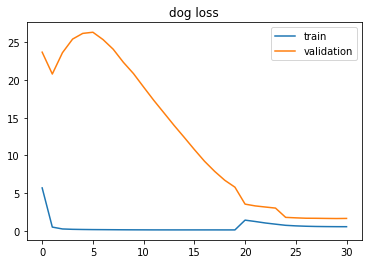

auc =  0.6302976111111112
[[3682 5318]
 [ 228  772]]
Loading  frog  data...


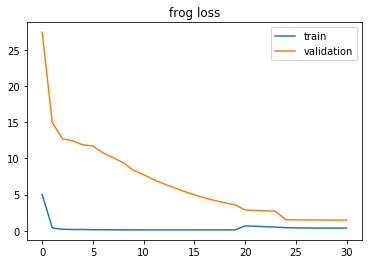

auc =  0.5384556666666667
[[3282 5718]
 [ 322  678]]
Loading  horse  data...


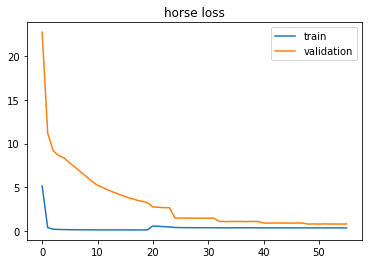

auc =  0.5323856666666666
[[4679 4321]
 [ 472  528]]
Loading  ship  data...


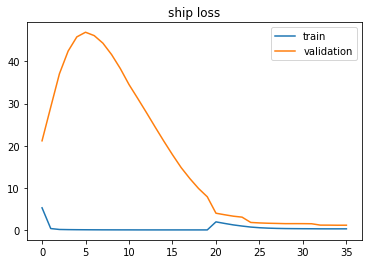

auc =  0.7034837222222222
[[ 148 8852]
 [  12  988]]
Loading  truck  data...


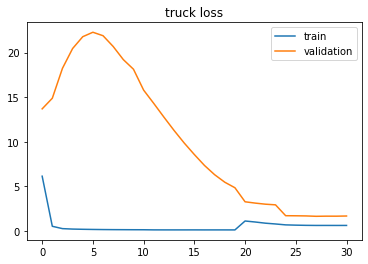

auc =  0.6496347222222223
[[7473 1527]
 [ 656  344]]


In [115]:
nu = 0.3
outlier_nu = 0.3

smoothing = 8
warm_up_n_epochs = 20
lr_milestone = 12
lr_change = 0.1
label_list = []
auc_list = []
time_list = []
confusionmatrix_list = []
for label_num in np.arange(10):
    x_train, x_test, y_train, y_test = load_data(label_num = label_num, batch_size = 200, outlier_nu = outlier_nu)
    
    no_vali_dataset, train_dataset, x_vali_tensor, n_samples, validation_n = split_data(x_train)
    ## 利用validation data 決定訓練epoch
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(no_vali_dataset , encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, n_samples, validation_n,
                                     smoothing, warm_up_n_epochs, lr_milestone, lr_change)
    epoch_n = train_SVDD.valistation_train( no_vali_dataset, x_vali_tensor)
    ## 利用train data 訓練所有資料
    pre_time = time.time()
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(train_dataset , encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, n_samples, validation_n,
                                     smoothing, warm_up_n_epochs, lr_milestone, lr_change)
    train_SVDD.last_train(train_dataset, epoch_n)
    ## 訓練結果
    test_auc, confusionmatrix = train_SVDD.test_result(x_test, y_test, load_model = True)
    print('auc = ', test_auc)
    print(confusionmatrix)
    train_time = time.time() - pre_time
    label_list.append(label_num)
    auc_list.append(test_auc)
    time_list.append(train_time)
    confusionmatrix_list.append(confusionmatrix)


In [116]:
#outlier_nu = 0.3, nu = 0.3, smoothing = 3, warm_up_n_epochs = 10, lr_milestone = 30, lr_change = 0.1
for i in range(len(names)):
    print('label = ', names[i])
    print('auc = ', auc_list[i])
    print('time = ', time_list[i])
    print(confusionmatrix_list[i])

label =  airplane
auc =  0.5419833333333333
time =  25.46647572517395
[[   2 8998]
 [   3  997]]
label =  automobile
auc =  0.5640042222222222
time =  20.20270800590515
[[6070 2930]
 [ 599  401]]
label =  bird
auc =  0.46712566666666666
time =  20.083166360855103
[[   3 8997]
 [   1  999]]
label =  cat
auc =  0.5952065
time =  35.86317563056946
[[1986 7014]
 [ 123  877]]
label =  deer
auc =  0.5127908333333334
time =  27.516376733779907
[[ 754 8246]
 [  89  911]]
label =  dog
auc =  0.6302976111111112
time =  20.85120725631714
[[3682 5318]
 [ 228  772]]
label =  frog
auc =  0.5384556666666667
time =  20.669032335281372
[[3282 5718]
 [ 322  678]]
label =  horse
auc =  0.5323856666666666
time =  48.701711893081665
[[4679 4321]
 [ 472  528]]
label =  ship
auc =  0.7034837222222222
time =  25.68870186805725
[[ 148 8852]
 [  12  988]]
label =  truck
auc =  0.6496347222222223
time =  20.89106059074402
[[7473 1527]
 [ 656  344]]


Loading  airplane  data...


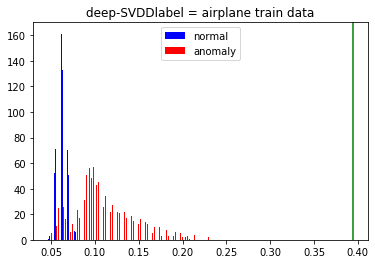

 train label = airplane uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 0 distance oder


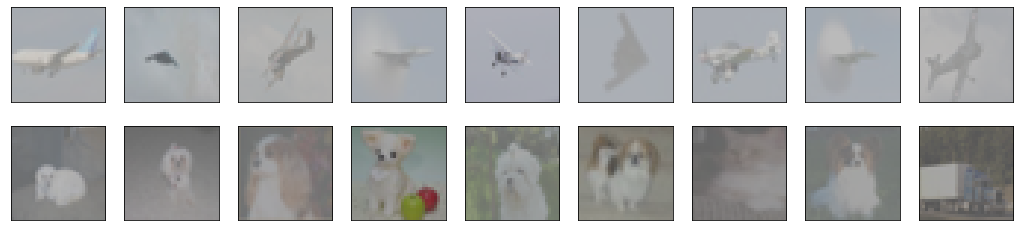

train label = airplane false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7173042222222222
confusion_matrix:
[[   0 9000]
 [   0 1000]]


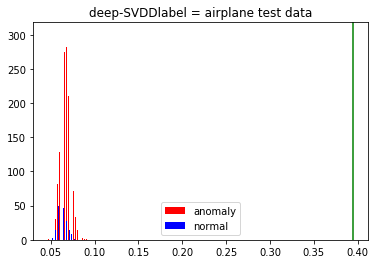

test label = airplane uncertain_img


<Figure size 1440x288 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test label = airplane distance oder


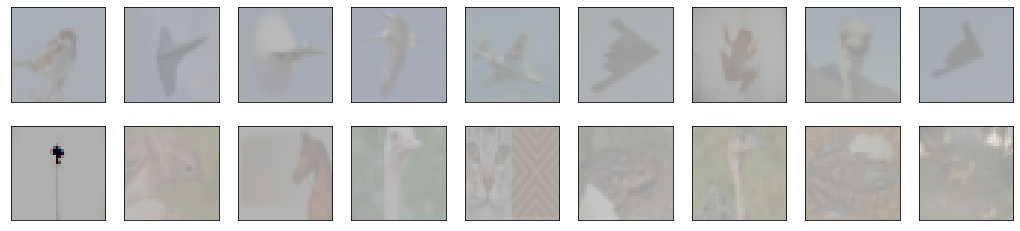

test label = airplane false_img


<Figure size 1440x288 with 0 Axes>

Loading  automobile  data...


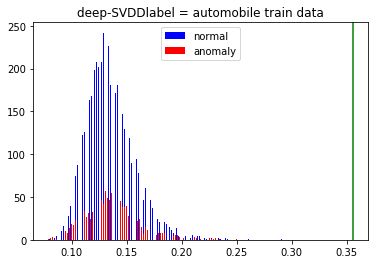

 train label = automobile uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 1 distance oder


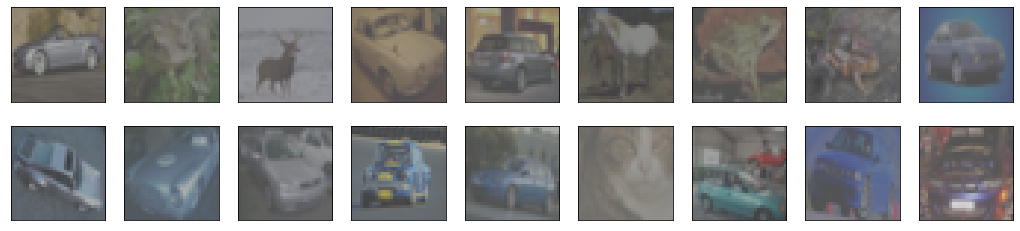

train label = automobile false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.5589242777777779
confusion_matrix:
[[   1 8999]
 [   0 1000]]


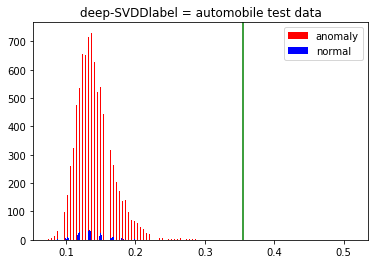

test label = automobile uncertain_img


<Figure size 1440x288 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test label = automobile distance oder


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


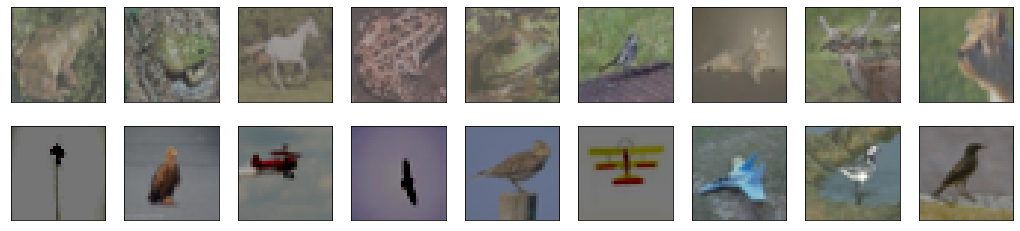

test label = automobile false_img


<Figure size 1440x288 with 0 Axes>

Loading  bird  data...


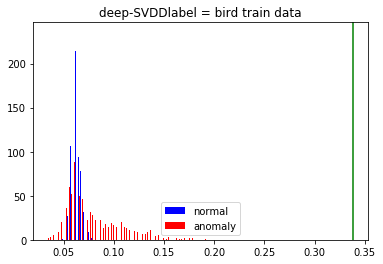

 train label = bird uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 2 distance oder


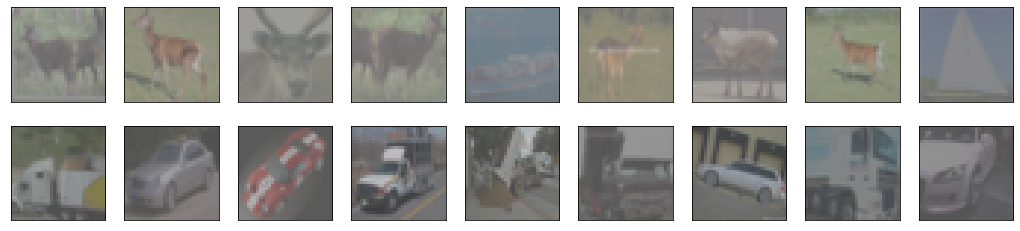

train label = bird false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.5089954444444444
confusion_matrix:
[[   0 9000]
 [   0 1000]]


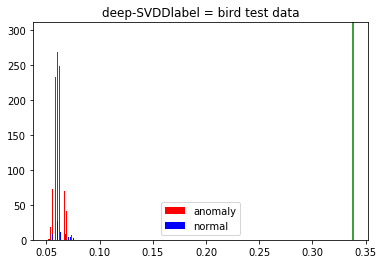

test label = bird uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = bird distance oder


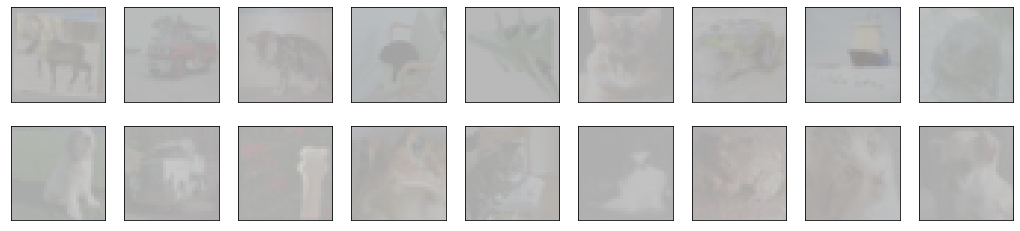

test label = bird false_img


<Figure size 1440x288 with 0 Axes>

Loading  cat  data...


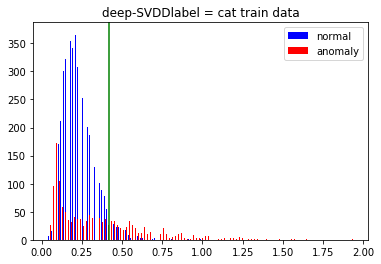

 train label = cat uncertain_img


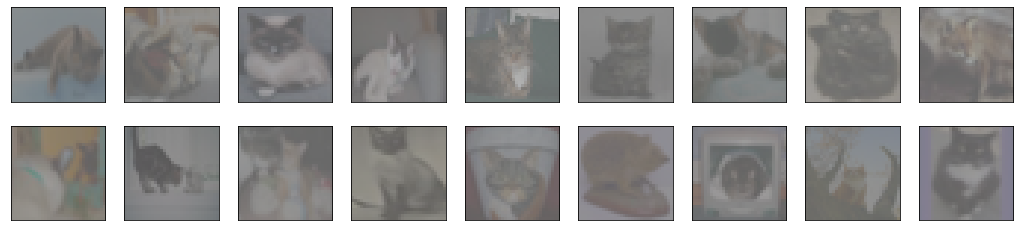

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train label = 3 distance oder


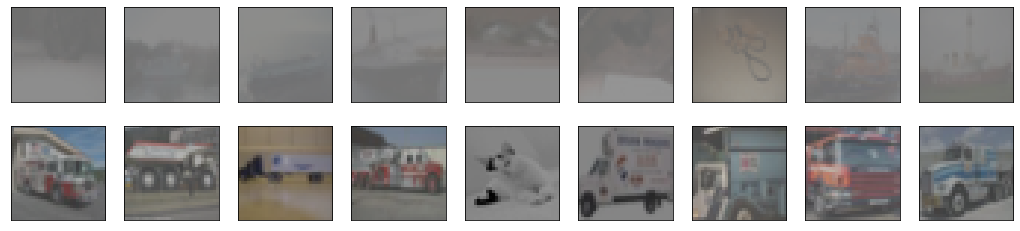

train label = cat false_img


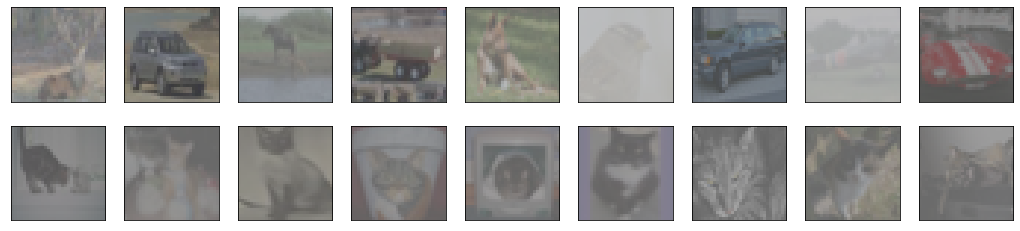

AUC: 0.5865472777777778
confusion_matrix:
[[1174 7826]
 [  70  930]]


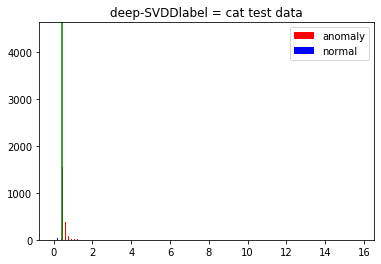

test label = cat uncertain_img


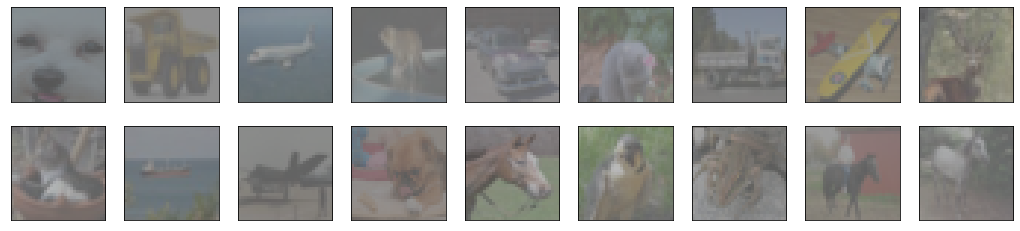

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test label = cat distance oder


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


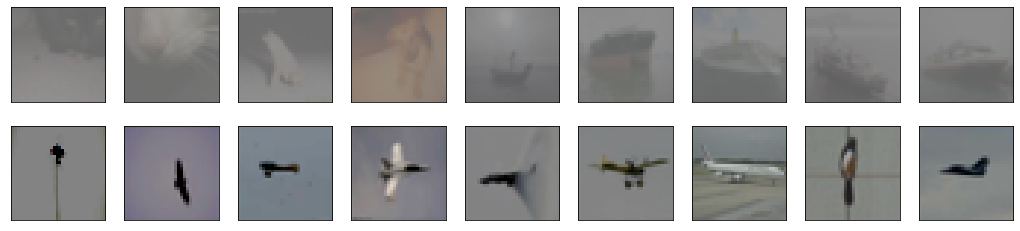

test label = cat false_img


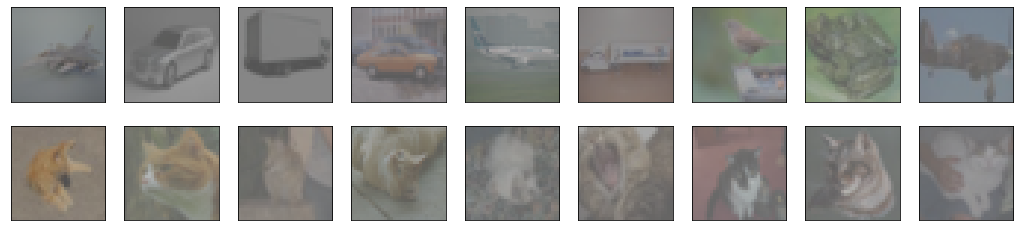

Loading  deer  data...


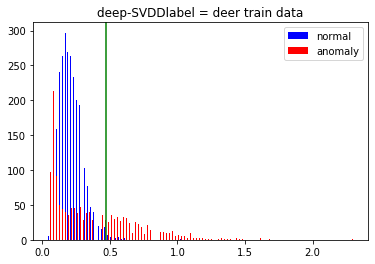

 train label = deer uncertain_img


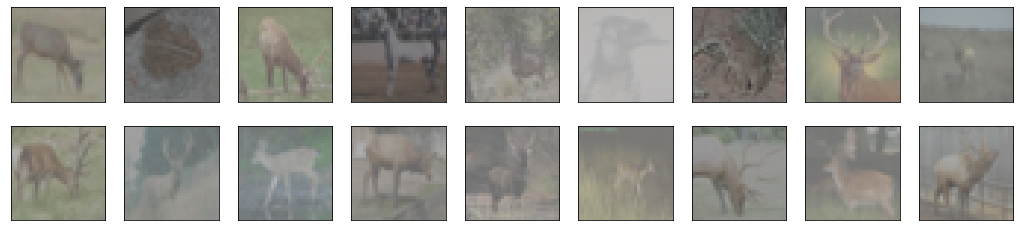

train label = 4 distance oder


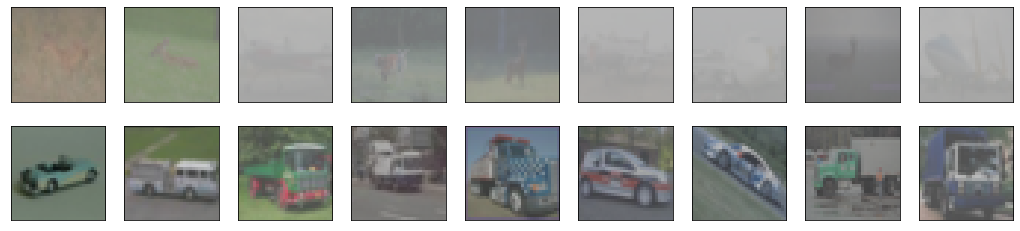

train label = deer false_img


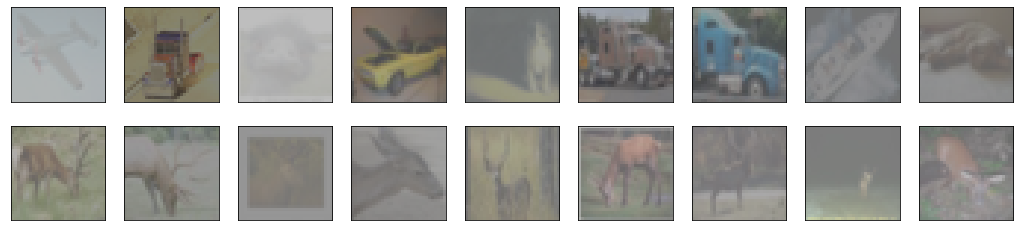

AUC: 0.5279521666666667
confusion_matrix:
[[ 363 8637]
 [  18  982]]


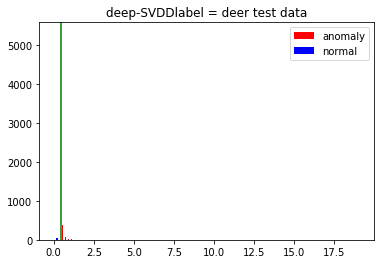

test label = deer uncertain_img


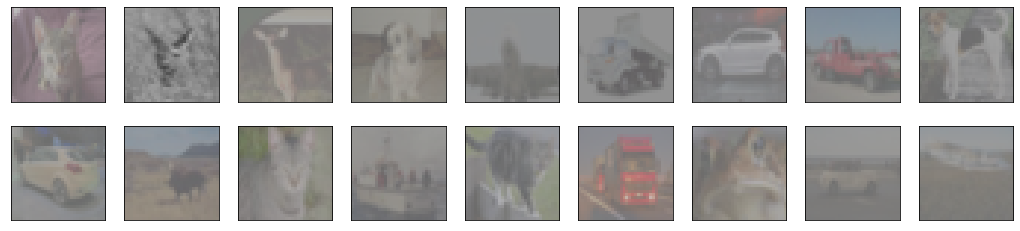

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test label = deer distance oder


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


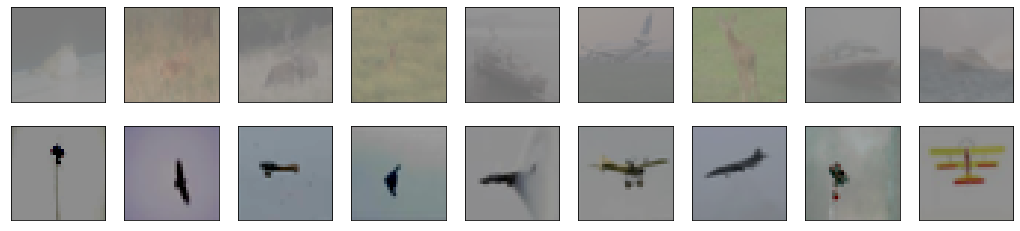

test label = deer false_img


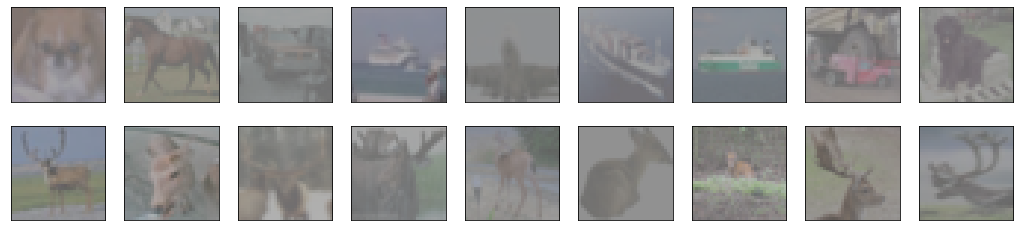

Loading  dog  data...


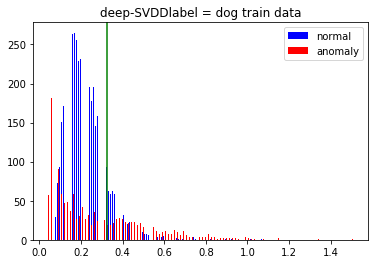

 train label = dog uncertain_img


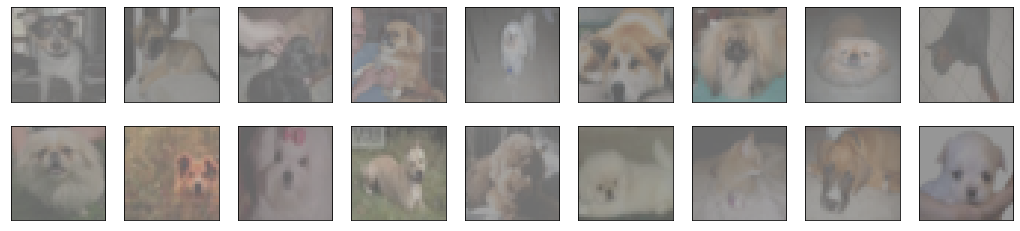

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train label = 5 distance oder


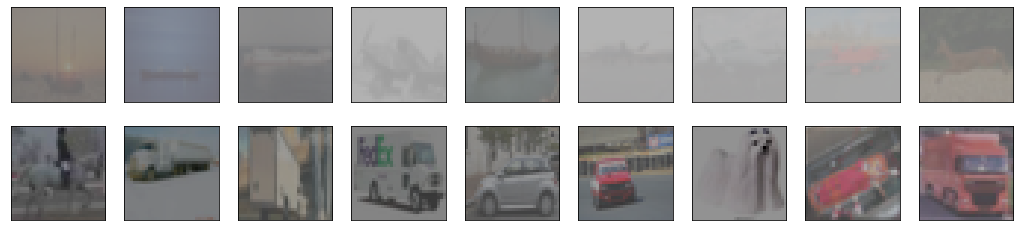

train label = dog false_img


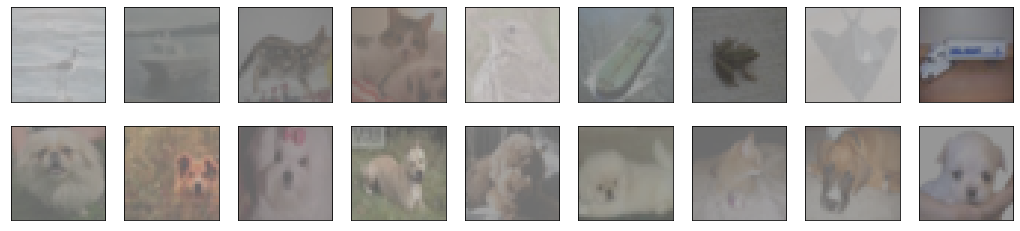

AUC: 0.6063069444444444
confusion_matrix:
[[2132 6868]
 [ 128  872]]


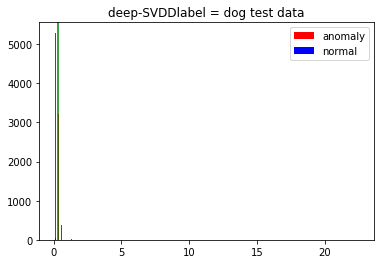

test label = dog uncertain_img


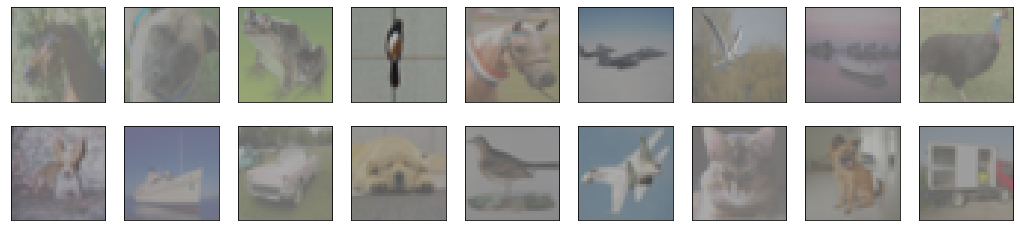

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test label = dog distance oder


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


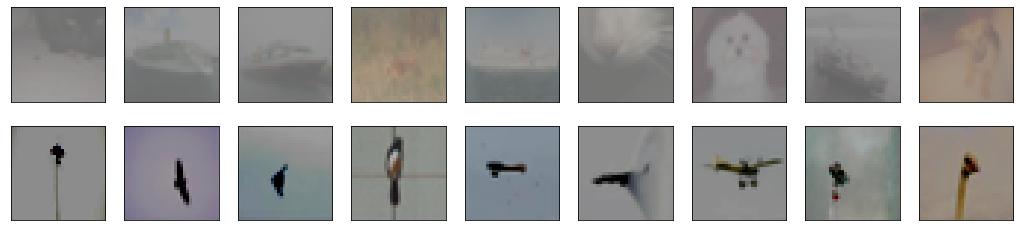

test label = dog false_img


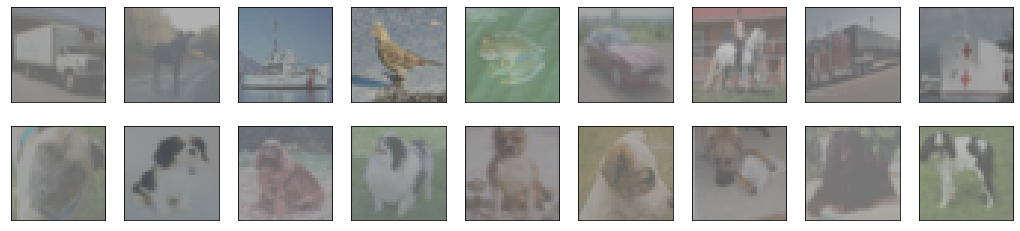

Loading  frog  data...


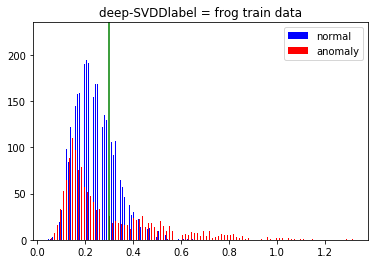

 train label = frog uncertain_img


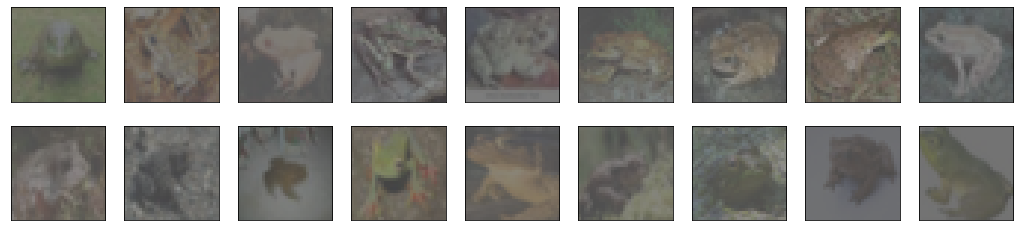

train label = 6 distance oder


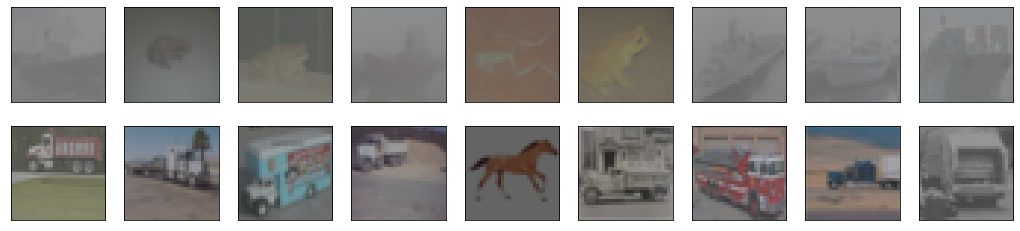

train label = frog false_img


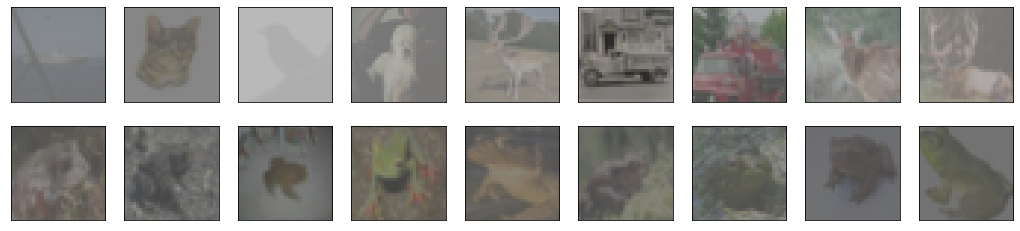

AUC: 0.5573707222222223
confusion_matrix:
[[3065 5935]
 [ 264  736]]


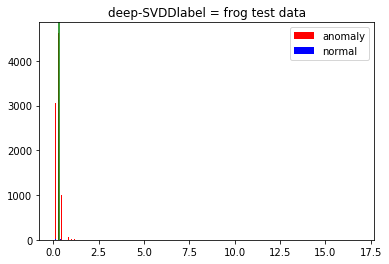

test label = frog uncertain_img


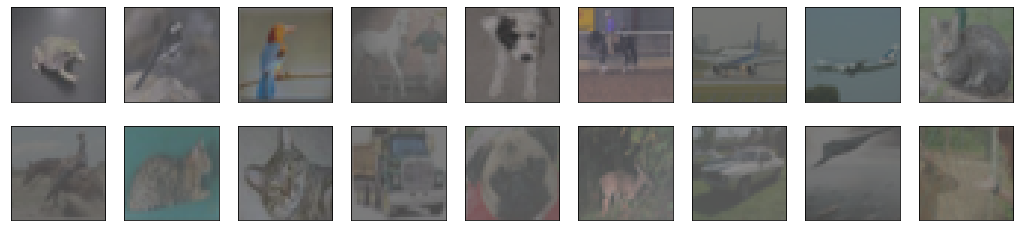

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test label = frog distance oder


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


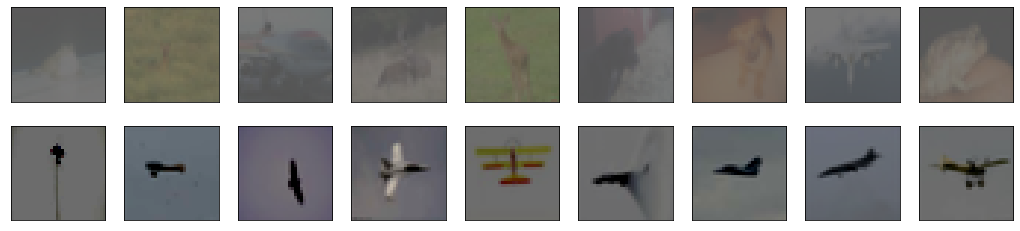

test label = frog false_img


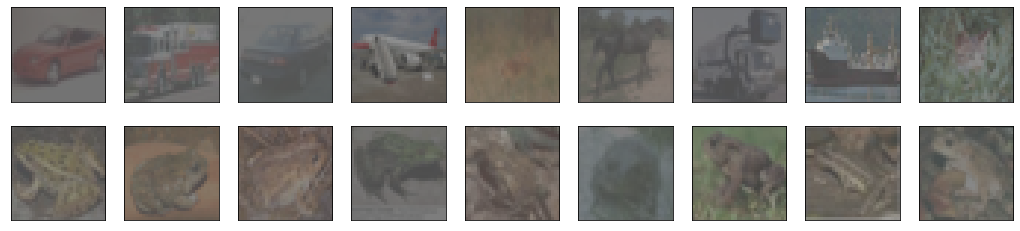

Loading  horse  data...


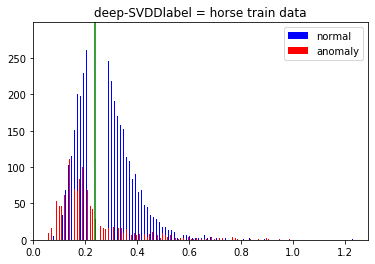

 train label = horse uncertain_img


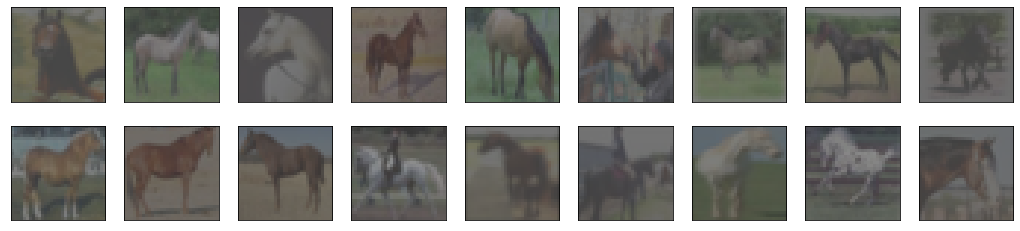

train label = 7 distance oder


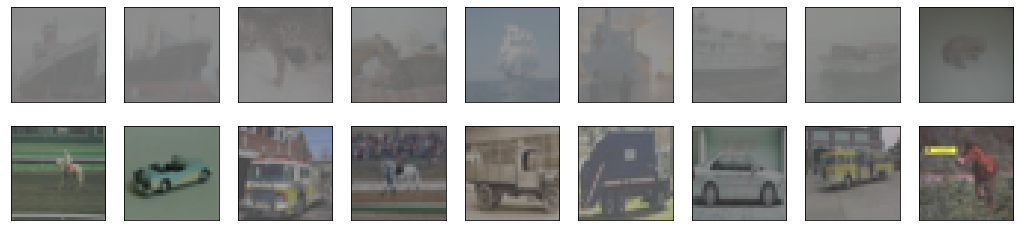

train label = horse false_img


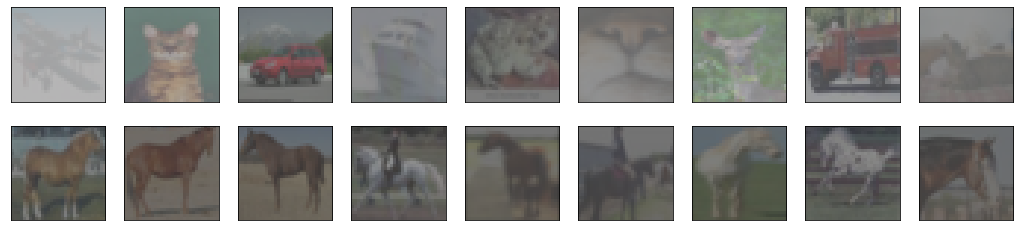

AUC: 0.5850372222222222
confusion_matrix:
[[6350 2650]
 [ 622  378]]


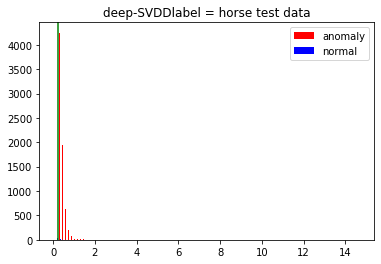

test label = horse uncertain_img


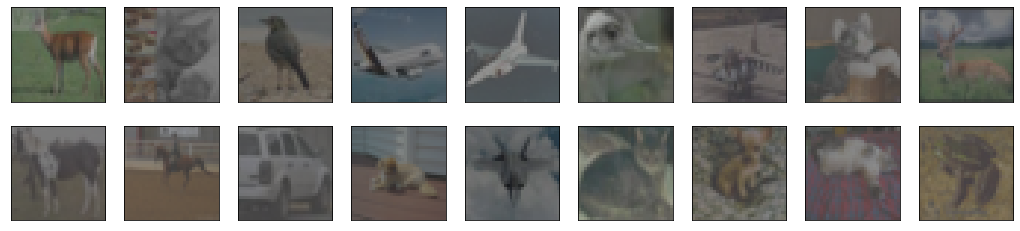

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test label = horse distance oder


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


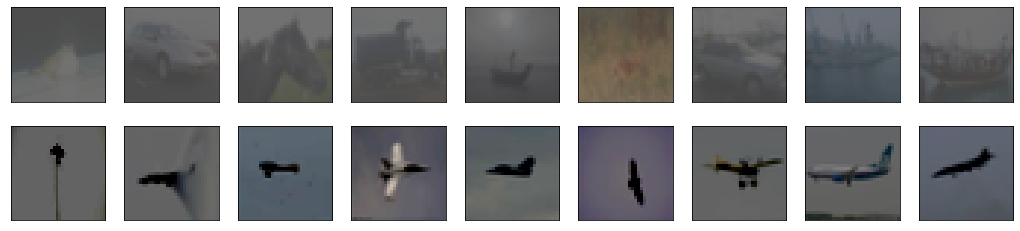

test label = horse false_img


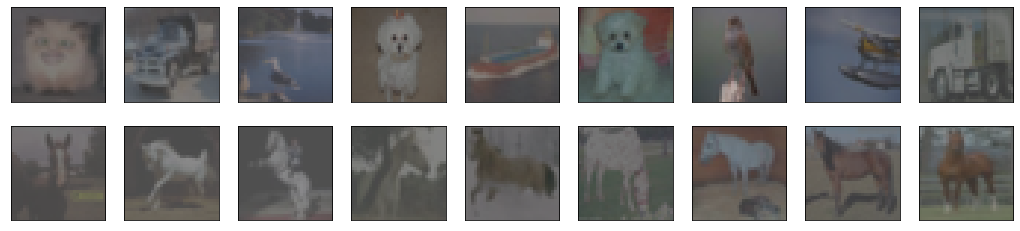

Loading  ship  data...


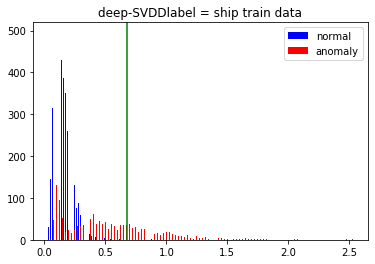

 train label = ship uncertain_img


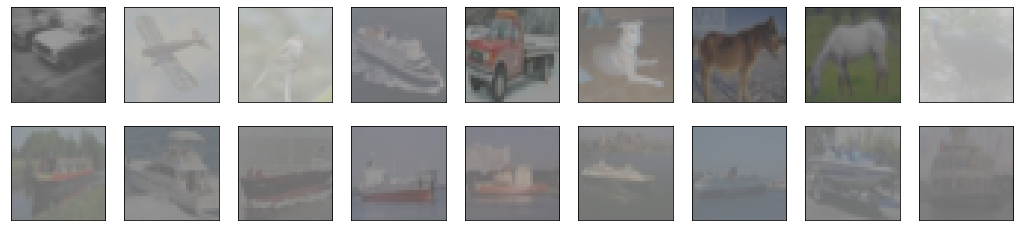

train label = 8 distance oder


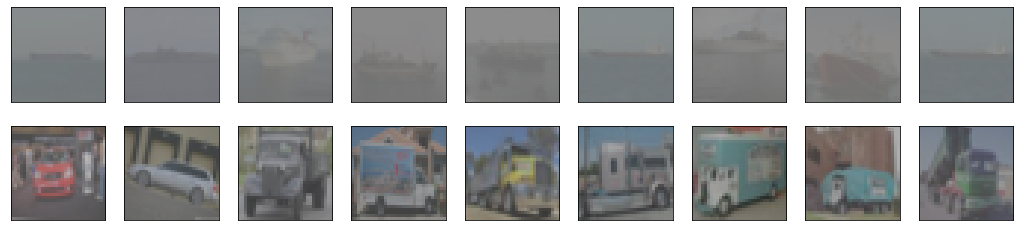

train label = ship false_img


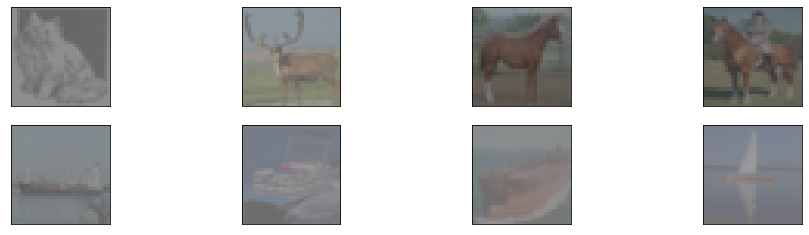

AUC: 0.7310145
confusion_matrix:
[[  39 8961]
 [   1  999]]


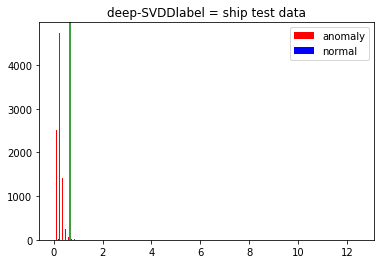

test label = ship uncertain_img


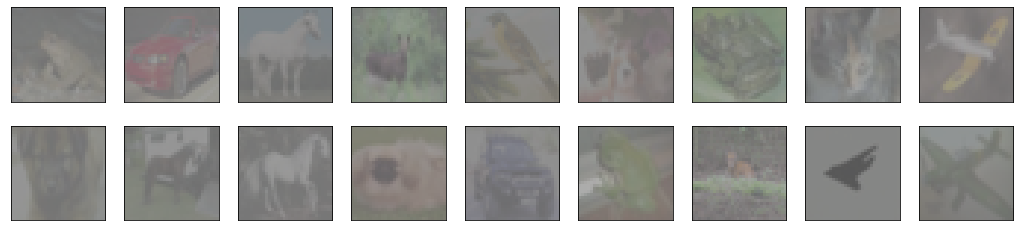

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test label = ship distance oder


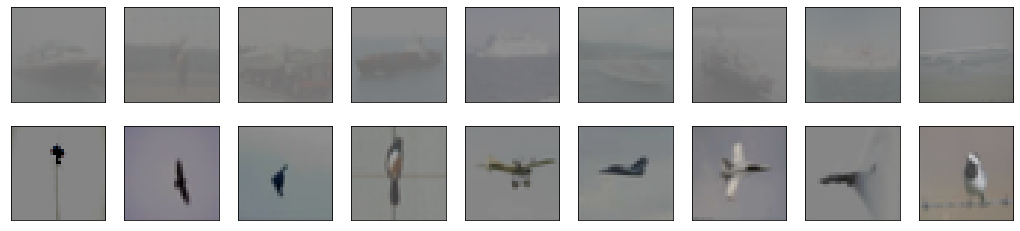

test label = ship false_img


<Figure size 1440x288 with 0 Axes>

Loading  truck  data...


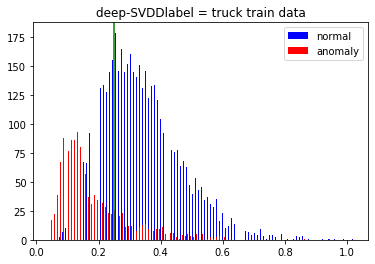

 train label = truck uncertain_img


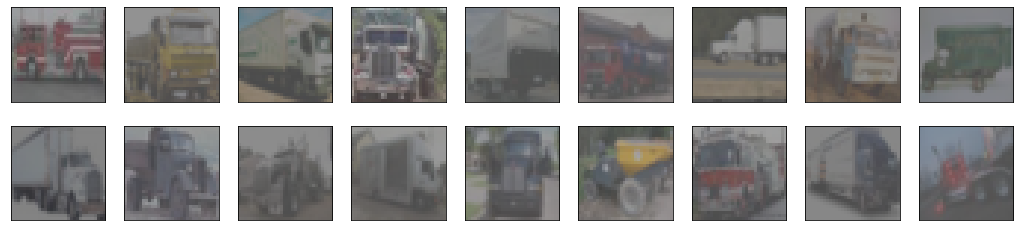

train label = 9 distance oder


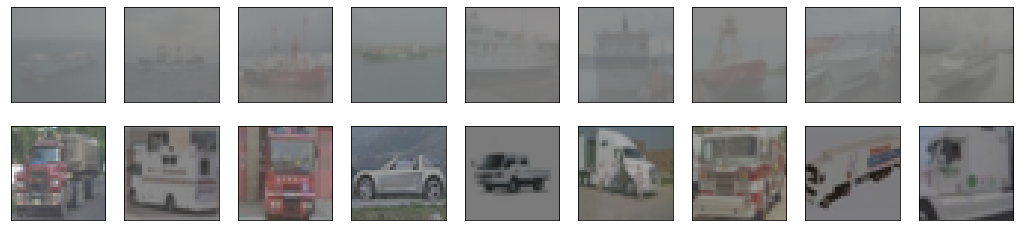

train label = truck false_img


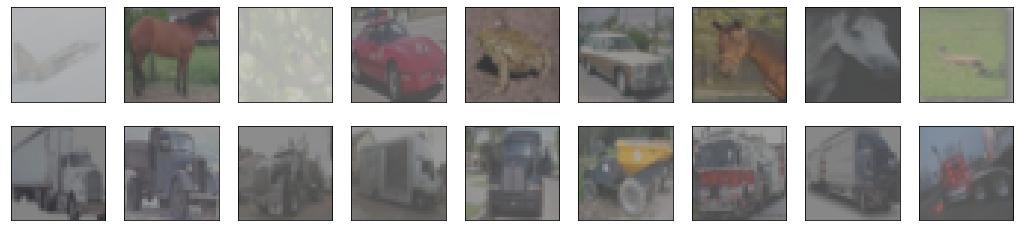

AUC: 0.5983573333333334
confusion_matrix:
[[7524 1476]
 [ 737  263]]


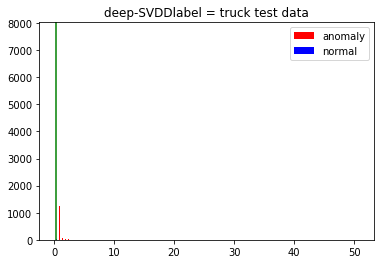

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test label = truck uncertain_img


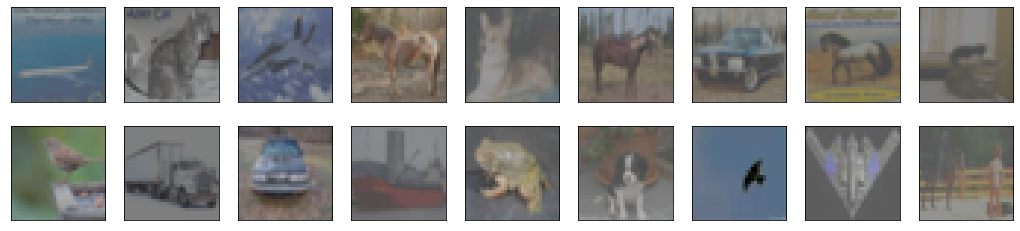

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test label = truck distance oder


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


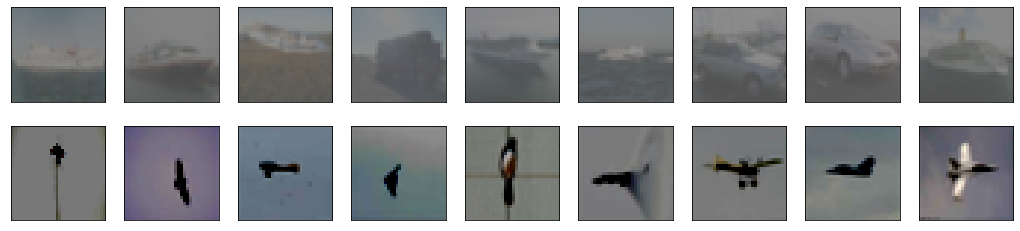

test label = truck false_img


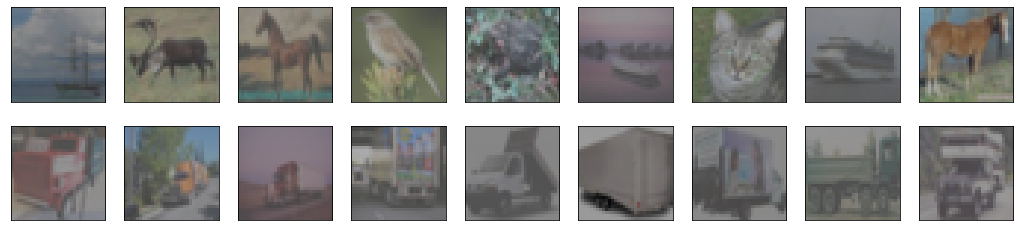

In [15]:
nu = 0.3
outlier_nu = 0.3

smoothing = 8
warm_up_n_epochs = 20
lr_milestone = 12
lr_change = 0.1
for label_num in np.arange(10):
    
    x_train, x_test, y_train, y_test = load_data(label_num = label_num, batch_size = 200, outlier_nu = outlier_nu)
    
    no_vali_dataset, train_dataset, x_vali_tensor, n_samples, validation_n = split_data(x_train)
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(train_dataset , encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, n_samples, validation_n,
                                     smoothing, warm_up_n_epochs, lr_milestone, lr_change)
    train_SVDD.train_result( x_train, y_train, load_model = True, show_img = True)
    test_auc, confusionmatrix = train_SVDD.test_result(x_test, y_test, load_model = True, show_img = True)
